<a href="https://colab.research.google.com/github/cherylktt/tensorflow/blob/main/10_time_series_forecasting_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

**Note:** This is not financial advice.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin. We downloaded the data from here: https://www.coindesk.com/price/bitcoin/

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-05-25 05:51:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-05-25 05:51:36 (8.41 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [3]:
# Import with pandas
import pandas as pd

# Read in the Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the data column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples. Typically, deep learning models usually like thousands to tens of thousands to millions of samples. A smaller number of samples is something you'll often run into with time series data problems.

> **Note:** The **seasonality** of a time series dataset is referred to as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [6]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


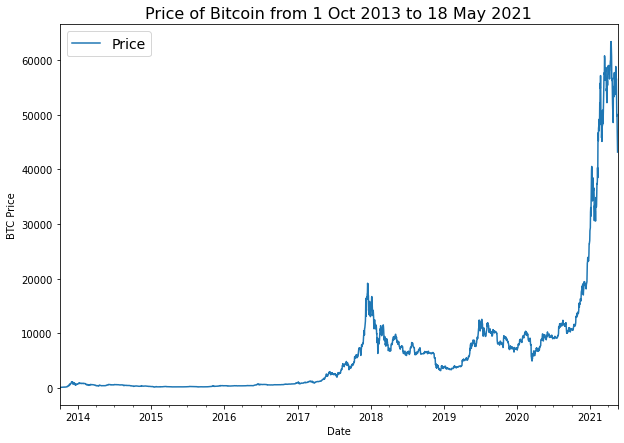

In [7]:
# Visualise the data
import matplotlib.pyplot as plt

bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings)
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

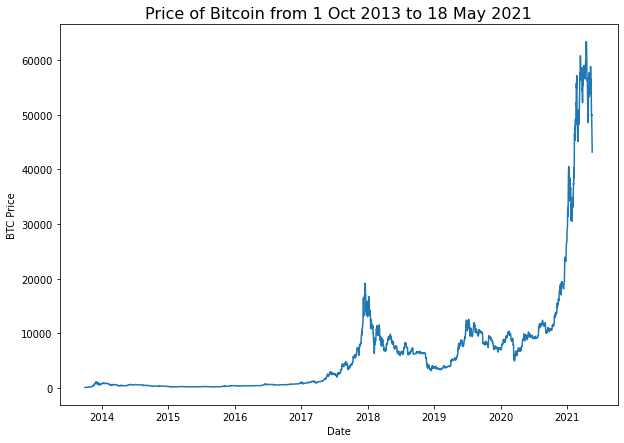

In [9]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16);

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [11]:
# Get Bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

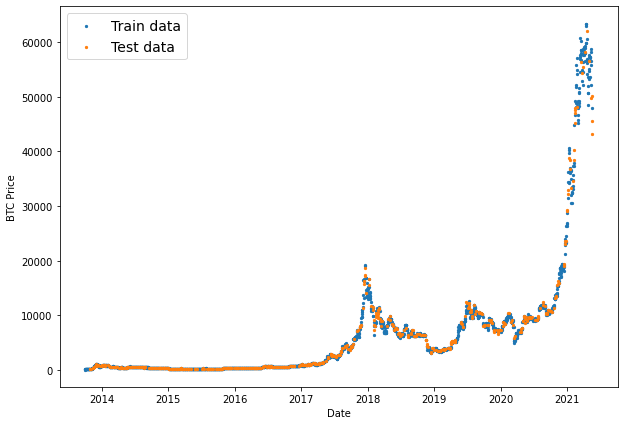

In [ ]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Creating train and test sets with time series data (the right way)

In [12]:
# Use indexing to create train and test sets the right way
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

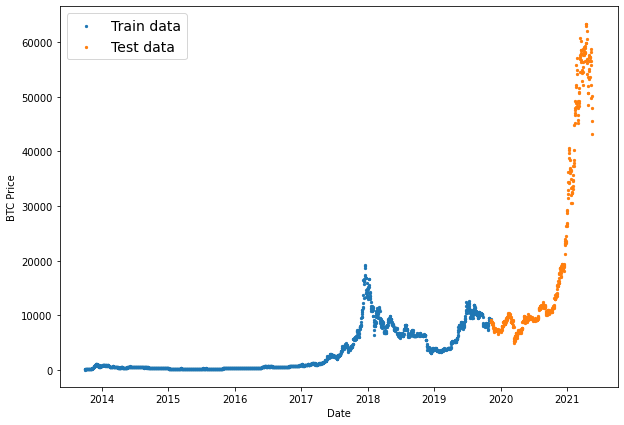

In [13]:
# Plot the correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Creating a plotting function

Typing plotting code is tedious, let's functionise it.

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):

  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).

  Args:
    timesteps: array of timesteps values
    values: array of values across time
    format: style of plot, default is "."
    start: where to start the plot (setting a value will index from start of timesteps & values)
    end : where to end the plot (similar to start but for the end)
    label: label to show on plot about values, default None
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")

  if label:
    plt.legend(fontsize=14)
  
  plt.grid(True);

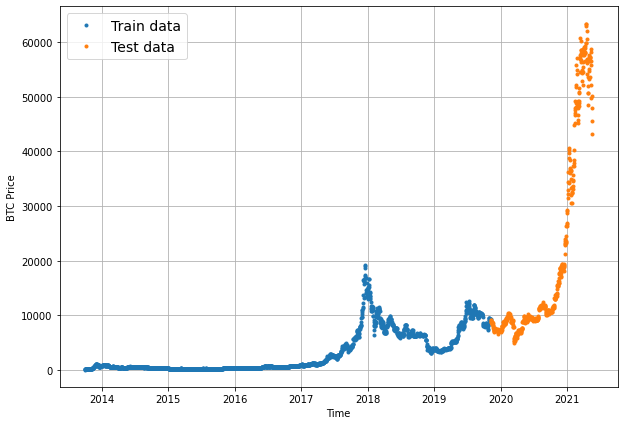

In [15]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling experiments

Now that we've got some Bitcoin historical data, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:

* `model_0`: Naive model (baseline)
* `model_1`: Dense model (horizon = 1, window size = 7)
* `model_2`: Same as `model_1` (horizon = 1, window size = 30)
* `model_3`: Same as `model_1` (horizon = 7, window size = 30)
* `model_4`: Conv1D
* `model_5`: LSTM
* `model_6`: Same as `model_1` but with multivariate data
* `model_7`: [N-BEATS algorithm](https://arxiv.org/abs/1905.10437)
* `model_8`: Ensemble (multiple models stacked together)
* `model_9`: Future prediction model
* `model_10`: Same as `model_1` but with turkey data introduced

## Model 0: Naive forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [40]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

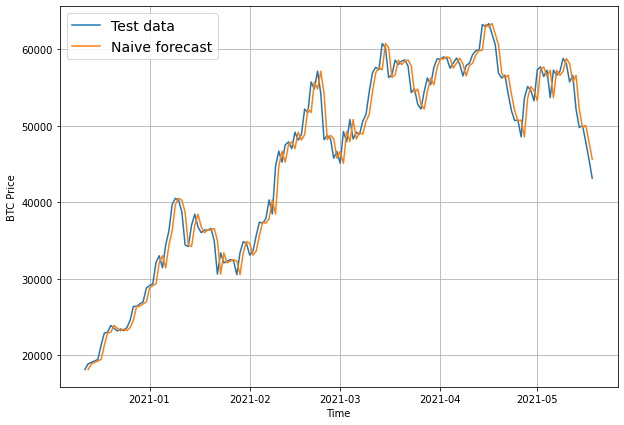

In [41]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
#plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=400, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=400, format="-", label="Naive forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

We're predicting a number, so that means we have a form of a regression problem. Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean squared error
* MAPE / sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

> A scaled error is **>1 if the forecast is worse than the naive** and **<1 if the forecast is better than the naive**.

For all the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecast (y_pred) against the actual values (y_true)?**

For a deeper dive on the various kinds of time series forecasting methods, see [Forecasting: Principles and Practice chapter 5.8](https://otexts.com/fpp3/accuracy.html)

In [16]:
import tensorflow as tf

In [17]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  
  """
  Implement MASE (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [42]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [18]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):

  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred).numpy()
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred).numpy()
  rmse = tf.sqrt(mse).numpy()
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred).numpy()
  mase = mean_absolute_scaled_error(y_true, y_pred).numpy()
  
  return {"mae": mae,
          "mse": mse,
          "rmse": rmse,
          "mape": mape,
          "mase": mase}

In [43]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models. However, there are plenty other styles of time series forecasting models available to experiment with: https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts

## Format Data Part 2: Windowing our dataset

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [19]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this: {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [20]:
# Let's set up global variables for window and horizon size
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use past week of data to make prediction

In [21]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  
  """
  Creates labels for windowed dataset.

  E.g. If horizon=1,
    Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """

  return x[:, :-horizon], x[:, -horizon:]

In [22]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label.numpy())}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data. However, this only works on a small scale. We need a way to do the above across our entire time series. We could use Python for loops, but for a large time series, that will take quite a while. 

To speed things up, we'll leverage NumPy's array indexing: https://numpy.org/doc/stable/reference/arrays.indexing.html

Our function will:
1. Create a window step of specific window size (e.g. `[0, 1, 2, 3, 4, 5, 6]`)
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0, 1, 2, 3, 4, 5, 6],
 [1, 2, 3, 4, 5, 6, 7],
 [2, 3, 4, 5, 6, 7, 8]]
 ```
3. Use the 2D array of multiple window steps from 2. to index on a target series (e.g. the historical price of Bitcoin)
4. Use our `get_labelled_windows()` function we created above to turn the window steps into windows with a specific horizon

The code is adapted from: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [23]:
# Create function to view NumPy arrays as windows
import numpy as np
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):

  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (a time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=HORIZON)

  return windows, labels

In [24]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [25]:
# View the first 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [26]:
# View the last 3 windows and labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


> **Note:** You can find a function which achieves similar results to the one we implemented above at [tf.keras.utils.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array). It also takes in an array and returns a windowed dataset, and has the benefit of returning data in the form of a tf.data.Dataset instance.

## Turning windows into training and test sets

In [27]:
# Make train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):

  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train, 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [28]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [29]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [30]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [31]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Creating a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare each model's best performanes against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

TensorFlow ModelCheckpoint callback: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [32]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="/content/drive/MyDrive/tensorflow/timeseries/model_experiments/"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=save_path + model_name,
                                            monitor="val_loss",
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

> **Hyperparameters** = values a machine learning practitioner can adjust themselves 

> **Parameters** = values a model learns on its own

In [33]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for reproducible results
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense")

# 2. Compile the model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
18/18 [==============================] - 6s 141ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 0s 29ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9993 - val_mae: 1005.9993 - val_mse: 3441833.2500
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.6094 - val_loss: 923.2862 - val_mae: 923.2861 - val_mse: 2868220.7500
Epoch 4/100
18/18 [==============================] - 1s 30ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5781 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.5000
Epoch 5/100
18/18 [==============================] - 1s 30ms/step - loss: 165.0894 - mae: 165.0894 - mse: 145490.7812 - val_loss: 895.2237 - val_mae: 895.2237 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 0s 28ms/step - loss: 158.

In [34]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [35]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

## Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actual forecasts, they are only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a trained model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [36]:
def make_preds(model, input_data):
  
  """
  Uses model to make predictions on input_data.
  """

  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [37]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.71 , 8769.887, 9015.711, 8795.519, 8723.811, 8730.111,
        8691.952, 8502.054, 8460.961, 8516.548], dtype=float32)>)

In [38]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4711}

In [44]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

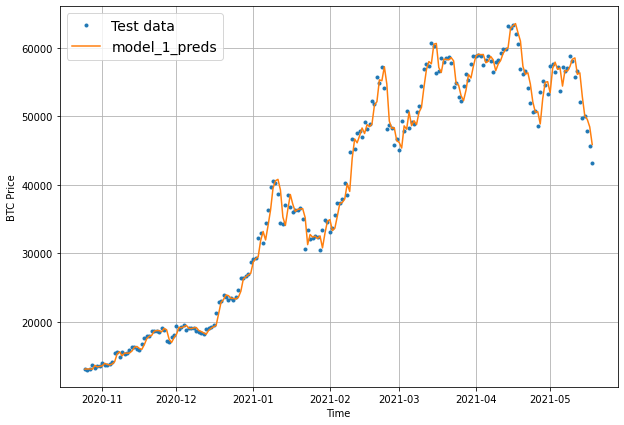

In [45]:
# Let's plot our model_1 predictions
offset = 350
plt.figure(figsize=(10, 7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2: Dense model (window = 30, horizon = 1)

In [ ]:
# Creating new windowed data with appropriate horizon and window sizes
WINDOW_SIZE=30

full_windows_30, full_labels_30 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and testing windows
train_windows_30, test_windows_30, train_labels_30, test_labels_30 = make_train_test_splits(full_windows_30, full_labels_30)

In [ ]:
# Create the model
tf.random.set_seed(42)

model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_2_dense_window_30")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_2.fit(x=train_windows_30,
            y=train_labels_30,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_30, test_labels_30),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
18/18 [==============================] - 2s 103ms/step - loss: 1097.0399 - mae: 1097.0399 - mse: 4741506.0000 - val_loss: 3900.2537 - val_mae: 3900.2537 - val_mse: 32752730.0000
Epoch 2/100
18/18 [==============================] - 0s 28ms/step - loss: 428.0732 - mae: 428.0732 - mse: 811548.2500 - val_loss: 1587.0745 - val_mae: 1587.0745 - val_mse: 6817661.5000
Epoch 3/100
18/18 [==============================] - 0s 27ms/step - loss: 279.7655 - mae: 279.7655 - mse: 363083.0625 - val_loss: 1220.6888 - val_mae: 1220.6888 - val_mse: 4447002.0000
Epoch 4/100
18/18 [==============================] - 0s 29ms/step - loss: 224.3637 - mae: 224.3637 - mse: 225072.2188 - val_loss: 1160.1572 - val_mae: 1160.1572 - val_mse: 3837504.2500
Epoch 5/100
18/18 [==============================] - 1s 29ms/step - loss: 187.9681 - mae: 187.9681 - mse: 173777.0312 - val_loss: 1007.6487 - val_mae: 1007.6487 - val_mse: 3224229.0000
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - los

In [ ]:
# Load in saved best performing model_2 and evaluate it on test data
model_2 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_2_dense_window_30")
model_2.evaluate(test_windows_30, test_labels_30)

18/18 [==============================] - 0s 2ms/step - loss: 605.8741 - mae: 605.8741 - mse: 1273360.7500


[605.8740844726562, 605.8740844726562, 1273360.75]

In [ ]:
# Make predictions and view results
model_2_preds = make_preds(model_2, input_data=test_windows_30)
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels_30), y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mape': 2.726445,
 'mase': 1.0590738,
 'mse': 1273360.8,
 'rmse': 1128.4329}

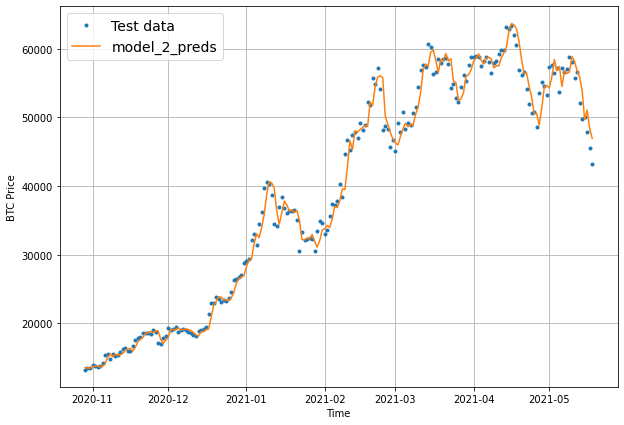

In [ ]:
# Let's plot our model_2 predictions
offset = 350
plt.figure(figsize=(10, 7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows_30):],
                 values=test_labels_30[:, 0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows_30):],
                 values=model_2_preds,
                 start=offset,
                 format="-",
                 label="model_2_preds")

## Model 3: Dense model (window = 30, horizon = 7)

In [ ]:
# Creating new windowed data with appropriate horizon and window sizes
HORIZON = 7

full_windows_30_7, full_labels_30_7 = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and testing windows
train_windows_30_7, test_windows_30_7, train_labels_30_7, test_labels_30_7 = make_train_test_splits(full_windows_30_7, full_labels_30_7)

In [ ]:
# Create the model
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_3_dense_window_30_horizon_7")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_3.fit(x=train_windows_30_7,
            y=train_labels_30_7,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows_30_7, test_labels_30_7),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
18/18 [==============================] - 2s 98ms/step - loss: 1476.6752 - mae: 1476.6752 - mse: 10390733.0000 - val_loss: 3088.5613 - val_mae: 3088.5613 - val_mse: 24386346.0000
Epoch 2/100
18/18 [==============================] - 0s 28ms/step - loss: 552.8943 - mae: 552.8943 - mse: 1336176.8750 - val_loss: 2462.4548 - val_mae: 2462.4548 - val_mse: 17112268.0000
Epoch 3/100
18/18 [==============================] - 1s 30ms/step - loss: 435.1978 - mae: 435.1978 - mse: 893449.0000 - val_loss: 2283.1484 - val_mae: 2283.1484 - val_mse: 14950889.0000
Epoch 4/100
18/18 [==============================] - 0s 29ms/step - loss: 391.9787 - mae: 391.9787 - mse: 745983.8125 - val_loss: 1975.1218 - val_mae: 1975.1218 - val_mse: 11680637.0000
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 357.9485 - mae: 357.9485 - mse: 627137.9375 - val_loss: 2000.1556 - val_mae: 2000.1556 - val_mse: 11665231.0000
Epoch 6/100
18/18 [==============================] - 1s 29ms/step 

In [ ]:
# Load in saved best performing model_3 and evaluate it on test data
model_3 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_3_dense_window_30_horizon_7")
model_3.evaluate(test_windows_30_7, test_labels_30_7)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5063 - mae: 1237.5063 - mse: 5405199.0000


[1237.50634765625, 1237.50634765625, 5405199.0]

In [ ]:
# Make predictions using model_3 on the test data
model_3_preds = make_preds(model_3, test_windows_30_7)
model_3_preds[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9004.694 , 9048.1   , 9425.09  , 9258.256 , 9495.797 , 9558.453 ,
        9357.3545],
       [8735.506 , 8840.303 , 9247.793 , 8885.601 , 9097.186 , 9174.327 ,
        9156.818 ],
       [8672.508 , 8782.387 , 9123.857 , 8770.371 , 9007.13  , 9003.869 ,
        9042.725 ],
       [8874.399 , 8784.74  , 9043.902 , 8943.052 , 9033.477 , 9176.489 ,
        9039.677 ],
       [8825.89  , 8777.44  , 8926.78  , 8870.179 , 9213.232 , 9268.156 ,
        8942.487 ]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels_30_7), y_pred=model_3_preds)
model_3_results

{'mae': array([ 513.6056  ,  355.08328 ,  327.17075 ,  358.5106  ,  420.53293 ,
         537.854   ,  545.6617  ,  485.9228  ,  584.49713 ,  687.38214 ,
         836.2264  ,  755.1576  ,  731.4957  ,  775.3399  ,  567.95544 ,
         266.80865 ,  188.80217 ,  188.10805 ,  253.095   ,  301.43256 ,
         151.10721 ,  196.8148  ,  191.46178 ,  231.65031 ,  143.61125 ,
         122.59089 ,  132.78871 ,  190.81174 ,  179.15994 ,  228.26004 ,
         314.44022 ,  379.09235 ,  278.32526 ,  295.34702 ,  299.3852  ,
         248.64983 ,  299.75668 ,  259.69434 ,  180.30531 ,  206.72922 ,
         374.62863 ,  144.85086 ,  142.33635 ,  131.11613 ,   93.9412  ,
          54.825542,   73.79555 ,  103.60121 ,  121.333916,  168.67278 ,
         183.90945 ,  152.25307 ,  186.57199 ,  146.91273 ,  240.42912 ,
         351.00656 ,  540.952   ,  549.1573  ,  521.2411  ,  526.8554  ,
         453.36237 ,  257.9811  ,  277.2947  ,  301.8247  ,  455.718   ,
         458.9603  ,  503.4438  ,  522.3119 

## Make our evaluation function work for larger horizons

In [ ]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):

  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different size metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single value
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels_30_7), y_pred=model_3_preds)
model_3_results

{'mae': 1237.5063,
 'mape': 5.5588784,
 'mase': 2.2020733,
 'mse': 5405198.5,
 'rmse': 1425.7477}

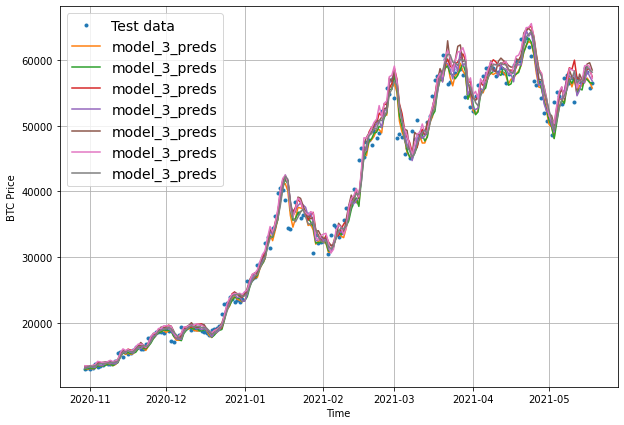

In [ ]:
# Let's plot model_3 predictions
offset = 350
plt.figure(figsize=(10, 7))

# Account for test_window offset
plot_time_series(timesteps=X_test[-len(test_windows_30_7):],
                 values=test_labels_30_7[:, 0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows_30_7):],
                 values=model_3_preds,
                 start=offset,
                 format="-",
                 label="model_3_preds")

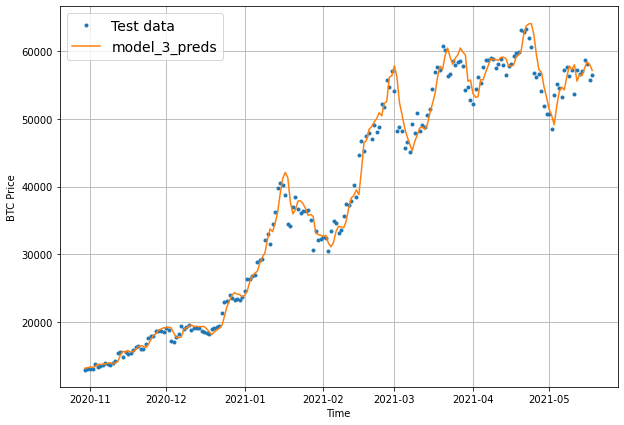

In [ ]:
# Aggregate model_3_preds using tf.reduce_mean()
offset = 350
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows_30_7):],
                 values=test_labels_30_7[:, 0],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows_30_7):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format="-",
                 label="model_3_preds")

## Comparing our model's performances

In [ ]:
model_0_to_3_results = pd.DataFrame({"naive_baseline": naive_results,
                                     "window_7_horizon_1": model_1_results,
                                     "window_30_horizon_1": model_2_results,
                                     "window_30_horizon_7": model_3_results}).transpose()
model_0_to_3_results

,mae,mse,rmse,mape,mase
naive_baseline,567.980225,1147547.00,1071.236206,2.516525,0.999570
window_7_horizon_1,568.951111,1171743.75,1082.471069,2.544898,0.999490
window_30_horizon_1,605.874084,1273360.75,1128.432861,2.726445,1.059074
window_30_horizon_7,1237.506348,5405198.50,1425.747681,5.558878,2.202073


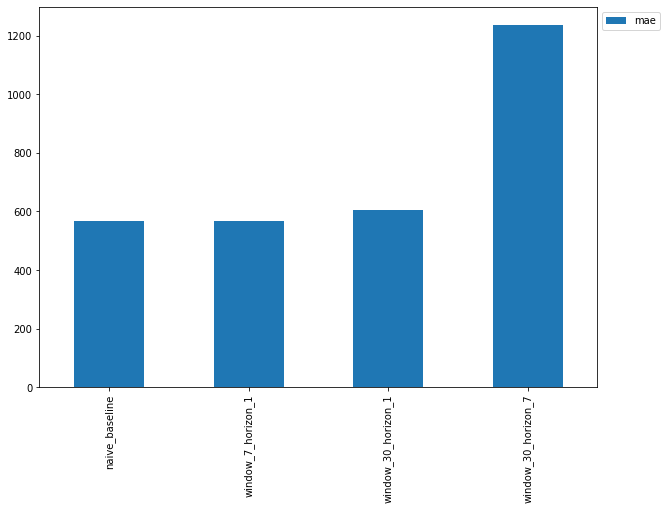

In [ ]:
model_0_to_3_results["mae"].plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

> **Note:** Why are the naive results so good? One of the reasons could be due to the presence of **autocorrelation** in the data. If a time series has **autocorrelation**, it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this is not always the case, but when it is, a naive model will often get fairly good results. 

> For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424) by Vegard Flovik

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train and test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`

However, our data isn't in that shape yet.

In [ ]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE,)

(7,)

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [ ]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for `input_dim`

In [ ]:
# Test out our lambda layer
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create Conv1D
model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128,
                kernel_size=7,
                padding="causal",
                activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_4_conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_4.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - 10s 116ms/step - loss: 1486.8540 - mae: 1486.8540 - mse: 7163934.0000 - val_loss: 1494.0684 - val_mae: 1494.0684 - val_mse: 6783190.5000
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 359.4668 - mae: 359.4668 - mse: 516577.5625 - val_loss: 1882.3083 - val_mae: 1882.3083 - val_mse: 8488888.0000
Epoch 3/100
18/18 [==============================] - 1s 39ms/step - loss: 237.6437 - mae: 237.6437 - mse: 276178.0000 - val_loss: 1228.2827 - val_mae: 1228.2827 - val_mse: 4507090.0000
Epoch 4/100
18/18 [==============================] - 1s 40ms/step - loss: 208.5991 - mae: 208.5991 - mse: 216257.3906 - val_loss: 1095.6581 - val_mae: 1095.6581 - val_mse: 4010961.0000
Epoch 5/100
18/18 [==============================] - 1s 40ms/step - loss: 197.1485 - mae: 197.1485 - mse: 201763.0156 - val_loss: 1087.9990 - val_mae: 1087.9990 - val_mse: 3871239.7500
Epoch 6/100
18/18 [==============================] - 1s 41ms/step - los

In [ ]:
# Load in saved best performing model_4 and evaluate it on test data
model_4 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 570.7388 - mae: 570.7388 - mse: 1183500.0000


[570.73876953125, 570.73876953125, 1183500.0]

In [ ]:
# Make predictions and view results
model_4_preds = make_preds(model_4, test_windows)
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)
model_4_results

{'mae': 570.7388,
 'mape': 2.5461204,
 'mase': 1.00263,
 'mse': 1183499.9,
 'rmse': 1087.8878}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data. We'll use the same data we created previously.

In [ ]:
tf.random.set_seed(42)

# Create LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
#x = layers.LSTM(units=128, return_sequences=True)(x)
x = layers.LSTM(units=128, activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON, activation="linear")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_LSTM")

model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_5.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 2544.1982 - mae: 2544.1982 - mse: 15832399.0000 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 7s 325ms/step - loss: 2323.6082 - mae: 2323.6082 - mse: 13451164.0000 - val_loss: 9222.6523 - val_mae: 9222.6523 - val_mse: 150544848.0000
Epoch 2/100
 9/18 [==============>...............] - ETA: 0s - loss: 1004.5931 - mae: 1004.5931 - mse: 2683788.5000INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 695.4739 - mae: 695.4739 - mse: 1664331.0000 - val_loss: 1486.0555 - val_mae: 1486.0555 - val_mse: 6266154.5000
Epoch 3/100
10/18 [===============>..............] - ETA: 0s - loss: 273.4720 - mae: 273.4720 - mse: 288615.3438INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 237.3967 - mae: 237.3967 - mse: 238510.3281 - val_loss: 1298.9084 - val_mae: 1298.9084 - val_mse: 4394857.5000
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 196.5330 - mae: 196.5330 - mse: 197479.2500INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 120ms/step - loss: 181.9180 - mae: 181.9180 - mse: 168791.5625 - val_loss: 966.6431 - val_mae: 966.6431 - val_mse: 3159459.2500
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 173.4022 - mae: 173.4022 - mse: 159026.5625 - val_loss: 970.9295 - val_mae: 970.9295 - val_mse: 3095508.5000
Epoch 6/100
11/18 [=================>............] - ETA: 0s - loss: 169.3568 - mae: 169.3568 - mse: 137665.2031INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 173.5414 - mae: 173.5414 - mse: 154012.8281 - val_loss: 941.4746 - val_mae: 941.4746 - val_mse: 2827413.2500
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 181.8447 - mae: 181.8447 - mse: 181875.5625INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 170.3566 - mae: 170.3566 - mse: 155902.1719 - val_loss: 898.5215 - val_mae: 898.5215 - val_mse: 2614158.7500
Epoch 8/100
18/18 [==============================] - 0s 7ms/step - loss: 157.6712 - mae: 157.6712 - mse: 136152.3125 - val_loss: 914.8642 - val_mae: 914.8642 - val_mse: 2657904.7500
Epoch 9/100
18/18 [==============================] - 0s 6ms/step - loss: 166.5143 - mae: 166.5143 - mse: 146057.1719 - val_loss: 1079.0776 - val_mae: 1079.0776 - val_mse: 3372638.7500
Epoch 10/100
12/18 [===================>..........] - ETA: 0s - loss: 163.3890 - mae: 163.3890 - mse: 127556.3828INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 162.3369 - mae: 162.3369 - mse: 134529.5469 - val_loss: 877.1690 - val_mae: 877.1690 - val_mse: 2416075.5000
Epoch 11/100
18/18 [==============================] - 0s 8ms/step - loss: 163.0841 - mae: 163.0841 - mse: 142166.6875 - val_loss: 924.1126 - val_mae: 924.1127 - val_mse: 2880439.5000
Epoch 12/100
18/18 [==============================] - 0s 7ms/step - loss: 168.5598 - mae: 168.5598 - mse: 149940.1094 - val_loss: 941.6025 - val_mae: 941.6025 - val_mse: 2945409.0000
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 166.4726 - mae: 166.4726 - mse: 149715.0000 - val_loss: 934.8436 - val_mae: 934.8436 - val_mse: 2894061.0000
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 163.9537 - mae: 163.9537 - mse: 144073.3438 - val_loss: 920.2160 - val_mae: 920.2160 - val_mse: 2636641.0000
Epoch 15/100
11/18 [=================>............] - ETA: 0s - loss: 151.0251 - mae: 151.0251 -

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 120ms/step - loss: 152.9470 - mae: 152.9470 - mse: 123160.4453 - val_loss: 856.2653 - val_mae: 856.2653 - val_mse: 2465898.5000
Epoch 16/100
18/18 [==============================] - 0s 7ms/step - loss: 147.4420 - mae: 147.4420 - mse: 116629.3828 - val_loss: 898.9914 - val_mae: 898.9914 - val_mse: 2276295.7500
Epoch 17/100
18/18 [==============================] - 0s 7ms/step - loss: 151.0533 - mae: 151.0533 - mse: 118490.4844 - val_loss: 943.1418 - val_mae: 943.1418 - val_mse: 2741249.7500
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 157.8232 - mae: 157.8232 - mse: 135940.5000 - val_loss: 924.0046 - val_mae: 924.0046 - val_mse: 2666361.0000
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 155.9198 - mae: 155.9198 - mse: 133608.1875 - val_loss: 911.4753 - val_mae: 911.4753 - val_mse: 2607185.5000
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 155.6456 - mae: 155.64

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 105ms/step - loss: 146.8467 - mae: 146.8467 - mse: 120590.7266 - val_loss: 845.2782 - val_mae: 845.2782 - val_mse: 2279688.0000
Epoch 26/100
11/18 [=================>............] - ETA: 0s - loss: 145.1898 - mae: 145.1898 - mse: 110209.3672INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 145.9843 - mae: 145.9843 - mse: 118008.3594 - val_loss: 818.6807 - val_mae: 818.6807 - val_mse: 2195707.0000
Epoch 27/100
12/18 [===================>..........] - ETA: 0s - loss: 150.8635 - mae: 150.8635 - mse: 126791.1641INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 144.4289 - mae: 144.4289 - mse: 116627.6328 - val_loss: 804.3279 - val_mae: 804.3279 - val_mse: 2141244.2500
Epoch 28/100
11/18 [=================>............] - ETA: 0s - loss: 145.3607 - mae: 145.3607 - mse: 115623.1719INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 124ms/step - loss: 142.4610 - mae: 142.4610 - mse: 115313.7578 - val_loss: 789.0859 - val_mae: 789.0859 - val_mse: 2095049.6250
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 141.8739 - mae: 141.8739 - mse: 112794.9297 - val_loss: 806.6758 - val_mae: 806.6758 - val_mse: 2090220.2500
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 142.0521 - mae: 142.0521 - mse: 112808.3359 - val_loss: 794.8836 - val_mae: 794.8837 - val_mse: 2040775.6250
Epoch 31/100
11/18 [=================>............] - ETA: 0s - loss: 138.5929 - mae: 138.5929 - mse: 107576.3672INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 138.4690 - mae: 138.4690 - mse: 107980.4766 - val_loss: 773.2812 - val_mae: 773.2812 - val_mse: 1972856.3750
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 137.1986 - mae: 137.1986 - mse: 106284.4766INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 106ms/step - loss: 137.1986 - mae: 137.1986 - mse: 106284.4766 - val_loss: 772.2625 - val_mae: 772.2625 - val_mse: 1948036.6250
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 135.9342 - mae: 135.9342 - mse: 103751.0312 - val_loss: 786.4805 - val_mae: 786.4805 - val_mse: 1961976.8750
Epoch 34/100
17/18 [===========================>..] - ETA: 0s - loss: 135.5343 - mae: 135.5343 - mse: 103976.6797INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 121ms/step - loss: 136.1931 - mae: 136.1931 - mse: 104538.6016 - val_loss: 744.4506 - val_mae: 744.4506 - val_mse: 1886289.3750
Epoch 35/100
18/18 [==============================] - 0s 7ms/step - loss: 133.4513 - mae: 133.4513 - mse: 102255.5938 - val_loss: 756.2970 - val_mae: 756.2970 - val_mse: 1852667.6250
Epoch 36/100
11/18 [=================>............] - ETA: 0s - loss: 134.1216 - mae: 134.1216 - mse: 112246.3828INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 106ms/step - loss: 134.0992 - mae: 134.0992 - mse: 103215.3203 - val_loss: 735.1729 - val_mae: 735.1729 - val_mse: 1840291.6250
Epoch 37/100
18/18 [==============================] - 0s 7ms/step - loss: 130.6932 - mae: 130.6932 - mse: 99329.6328 - val_loss: 745.9099 - val_mae: 745.9099 - val_mse: 1796193.8750
Epoch 38/100
10/18 [===============>..............] - ETA: 0s - loss: 137.2887 - mae: 137.2887 - mse: 103603.9531INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 129.2891 - mae: 129.2891 - mse: 96651.1484 - val_loss: 717.2498 - val_mae: 717.2498 - val_mse: 1739678.7500
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 129.6088 - mae: 129.6088 - mse: 97402.8438 - val_loss: 719.0665 - val_mae: 719.0665 - val_mse: 1764965.1250
Epoch 40/100
18/18 [==============================] - 0s 9ms/step - loss: 129.6111 - mae: 129.6111 - mse: 96268.3438 - val_loss: 732.0632 - val_mae: 732.0632 - val_mse: 1722418.6250
Epoch 41/100
10/18 [===============>..............] - ETA: 0s - loss: 133.3553 - mae: 133.3553 - mse: 103149.5156INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 103ms/step - loss: 127.1393 - mae: 127.1393 - mse: 94059.6016 - val_loss: 702.9354 - val_mae: 702.9354 - val_mse: 1654539.1250
Epoch 42/100
10/18 [===============>..............] - ETA: 0s - loss: 121.0014 - mae: 121.0014 - mse: 89177.0156INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 123ms/step - loss: 125.6113 - mae: 125.6113 - mse: 93062.1250 - val_loss: 700.8702 - val_mae: 700.8702 - val_mse: 1632477.6250
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 125.9959 - mae: 125.9959 - mse: 91461.9453 - val_loss: 704.3682 - val_mae: 704.3682 - val_mse: 1634230.3750
Epoch 44/100
10/18 [===============>..............] - ETA: 0s - loss: 119.9876 - mae: 119.9876 - mse: 82793.8906INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 105ms/step - loss: 125.2241 - mae: 125.2241 - mse: 91130.9141 - val_loss: 698.7766 - val_mae: 698.7766 - val_mse: 1611164.0000
Epoch 45/100
10/18 [===============>..............] - ETA: 0s - loss: 125.0639 - mae: 125.0639 - mse: 85950.2266INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 100ms/step - loss: 122.5007 - mae: 122.5007 - mse: 87852.5938 - val_loss: 683.0590 - val_mae: 683.0590 - val_mse: 1587455.5000
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 130.0215 - mae: 130.0215 - mse: 100510.8984INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 118ms/step - loss: 124.4726 - mae: 124.4726 - mse: 89115.8672 - val_loss: 679.1873 - val_mae: 679.1873 - val_mse: 1563189.8750
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 122.1862 - mae: 122.1862 - mse: 88216.1328 - val_loss: 705.4241 - val_mae: 705.4241 - val_mse: 1601601.6250
Epoch 48/100
12/18 [===================>..........] - ETA: 0s - loss: 119.4245 - mae: 119.4245 - mse: 84762.6719INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 122.0458 - mae: 122.0458 - mse: 86790.4453 - val_loss: 677.0784 - val_mae: 677.0784 - val_mse: 1531911.8750
Epoch 49/100
11/18 [=================>............] - ETA: 0s - loss: 127.1128 - mae: 127.1128 - mse: 101568.7031INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 121.1548 - mae: 121.1548 - mse: 86714.9219 - val_loss: 674.6848 - val_mae: 674.6848 - val_mse: 1519799.5000
Epoch 50/100
18/18 [==============================] - 0s 8ms/step - loss: 122.8890 - mae: 122.8890 - mse: 86371.2188 - val_loss: 691.4816 - val_mae: 691.4816 - val_mse: 1621967.2500
Epoch 51/100
18/18 [==============================] - 0s 16ms/step - loss: 122.2994 - mae: 122.2994 - mse: 84443.6250 - val_loss: 737.3929 - val_mae: 737.3929 - val_mse: 1666765.1250
Epoch 52/100
15/18 [========================>.....] - ETA: 0s - loss: 125.6958 - mae: 125.6958 - mse: 92822.2188INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 168ms/step - loss: 121.2944 - mae: 121.2944 - mse: 86066.5625 - val_loss: 657.2365 - val_mae: 657.2365 - val_mse: 1474019.0000
Epoch 53/100
10/18 [===============>..............] - ETA: 0s - loss: 114.9636 - mae: 114.9636 - mse: 79983.9141INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 121ms/step - loss: 119.7668 - mae: 119.7668 - mse: 85063.6797 - val_loss: 652.7970 - val_mae: 652.7970 - val_mse: 1469353.0000
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 120.1222 - mae: 120.1222 - mse: 85026.6719 - val_loss: 654.4439 - val_mae: 654.4439 - val_mse: 1453347.0000
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 125.5305 - mae: 125.5305 - mse: 92057.1875 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 119.2566 - mae: 119.2566 - mse: 84235.1953 - val_loss: 647.2831 - val_mae: 647.2831 - val_mse: 1439385.5000
Epoch 56/100
11/18 [=================>............] - ETA: 0s - loss: 122.4764 - mae: 122.4764 - mse: 95201.5156 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 120.0544 - mae: 120.0544 - mse: 85208.3594 - val_loss: 643.7808 - val_mae: 643.7808 - val_mse: 1432413.0000
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 123.1243 - mae: 123.1243 - mse: 86718.4453 - val_loss: 671.1797 - val_mae: 671.1797 - val_mse: 1477136.8750
Epoch 58/100
10/18 [===============>..............] - ETA: 0s - loss: 120.0865 - mae: 120.0865 - mse: 90863.8672INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 123ms/step - loss: 118.4059 - mae: 118.4059 - mse: 83857.0469 - val_loss: 640.2656 - val_mae: 640.2656 - val_mse: 1413273.5000
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 117.7119 - mae: 117.7119 - mse: 82616.7344 - val_loss: 645.3837 - val_mae: 645.3837 - val_mse: 1449263.0000
Epoch 60/100
12/18 [===================>..........] - ETA: 0s - loss: 117.1983 - mae: 117.1983 - mse: 80804.5938INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 118.5346 - mae: 118.5346 - mse: 81290.9062 - val_loss: 638.7429 - val_mae: 638.7429 - val_mse: 1401002.2500
Epoch 61/100
18/18 [==============================] - 0s 8ms/step - loss: 118.3129 - mae: 118.3129 - mse: 83193.3750 - val_loss: 689.4144 - val_mae: 689.4144 - val_mse: 1512748.3750
Epoch 62/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4350 - mae: 121.4350 - mse: 81419.4453 - val_loss: 748.5565 - val_mae: 748.5565 - val_mse: 1786019.2500
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 123.1006 - mae: 123.1006 - mse: 86016.2266 - val_loss: 651.8298 - val_mae: 651.8298 - val_mse: 1418997.8750
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 115.9679 - mae: 115.9679 - mse: 81176.8672 - val_loss: 672.9166 - val_mae: 672.9166 - val_mse: 1467748.0000
Epoch 65/100
11/18 [=================>............] - ETA: 0s - loss: 120.7008 - mae: 120.7008 - mse:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 118.8341 - mae: 118.8341 - mse: 83323.3047 - val_loss: 631.7538 - val_mae: 631.7538 - val_mse: 1396571.8750
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 116.2212 - mae: 116.2212 - mse: 80563.0859 - val_loss: 634.5445 - val_mae: 634.5445 - val_mse: 1376238.3750
Epoch 67/100
12/18 [===================>..........] - ETA: 0s - loss: 113.0850 - mae: 113.0850 - mse: 71994.2500INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 116.1580 - mae: 116.1580 - mse: 81177.6484 - val_loss: 623.8932 - val_mae: 623.8932 - val_mse: 1357601.1250
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5543 - mae: 115.5543 - mse: 79794.0156 - val_loss: 635.4929 - val_mae: 635.4929 - val_mse: 1408539.1250
Epoch 69/100
18/18 [==============================] - 0s 8ms/step - loss: 120.5866 - mae: 120.5866 - mse: 83005.6328 - val_loss: 626.3387 - val_mae: 626.3387 - val_mse: 1375137.2500
Epoch 70/100
11/18 [=================>............] - ETA: 0s - loss: 112.4539 - mae: 112.4539 - mse: 79753.8281 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 124ms/step - loss: 114.9188 - mae: 114.9188 - mse: 79743.3516 - val_loss: 619.3181 - val_mae: 619.3181 - val_mse: 1348408.0000
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8998 - mae: 114.8998 - mse: 79444.4609 - val_loss: 650.9373 - val_mae: 650.9373 - val_mse: 1404147.1250
Epoch 72/100
18/18 [==============================] - 0s 7ms/step - loss: 118.2033 - mae: 118.2033 - mse: 80784.2656 - val_loss: 630.5287 - val_mae: 630.5287 - val_mse: 1389130.3750
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 115.3612 - mae: 115.3612 - mse: 80023.2188 - val_loss: 623.0369 - val_mae: 623.0369 - val_mse: 1362779.1250
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 115.0345 - mae: 115.0345 - mse: 80069.8906 - val_loss: 623.0776 - val_mae: 623.0776 - val_mse: 1339281.8750
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2057 - mae: 115.2057 - 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 114.1402 - mae: 114.1402 - mse: 78923.9688 - val_loss: 614.4062 - val_mae: 614.4062 - val_mse: 1321707.2500
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5973 - mae: 115.5973 - mse: 77964.8750 - val_loss: 689.8776 - val_mae: 689.8776 - val_mse: 1484028.1250
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 117.2611 - mae: 117.2611 - mse: 80703.7891 - val_loss: 645.2790 - val_mae: 645.2790 - val_mse: 1380985.1250
Epoch 79/100
12/18 [===================>..........] - ETA: 0s - loss: 112.1790 - mae: 112.1790 - mse: 72114.9609INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 104ms/step - loss: 114.1995 - mae: 114.1995 - mse: 78555.1484 - val_loss: 608.7159 - val_mae: 608.7159 - val_mse: 1312046.2500
Epoch 80/100
18/18 [==============================] - 0s 8ms/step - loss: 112.7125 - mae: 112.7125 - mse: 77826.6797 - val_loss: 614.9222 - val_mae: 614.9222 - val_mse: 1316068.3750
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3684 - mae: 113.3684 - mse: 77013.3125 - val_loss: 634.8466 - val_mae: 634.8466 - val_mse: 1353791.8750
Epoch 82/100
11/18 [=================>............] - ETA: 0s - loss: 122.9989 - mae: 122.9989 - mse: 94740.7812 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 115.9701 - mae: 115.9701 - mse: 80798.4531 - val_loss: 607.8510 - val_mae: 607.8510 - val_mse: 1310004.2500
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3599 - mae: 113.3599 - mse: 77364.0781 - val_loss: 628.8181 - val_mae: 628.8181 - val_mse: 1372628.6250
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4113 - mae: 114.4113 - mse: 77286.6094 - val_loss: 628.5579 - val_mae: 628.5579 - val_mse: 1336987.6250
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8363 - mae: 114.8363 - mse: 77763.7812 - val_loss: 634.7715 - val_mae: 634.7715 - val_mse: 1349507.5000
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 115.5462 - mae: 115.5462 - mse: 79288.1016 - val_loss: 613.5223 - val_mae: 613.5223 - val_mse: 1306160.1250
Epoch 87/100
12/18 [===================>..........] - ETA: 0s - loss: 115.3621 - mae: 115.3621 - mse:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 119ms/step - loss: 112.5059 - mae: 112.5059 - mse: 77122.9297 - val_loss: 604.7603 - val_mae: 604.7603 - val_mse: 1301087.5000
Epoch 88/100
11/18 [=================>............] - ETA: 0s - loss: 114.8154 - mae: 114.8154 - mse: 85407.6172 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 101ms/step - loss: 111.7706 - mae: 111.7706 - mse: 77141.2969 - val_loss: 601.5748 - val_mae: 601.5748 - val_mse: 1286722.7500
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8470 - mae: 111.8470 - mse: 75809.6328 - val_loss: 624.0131 - val_mae: 624.0131 - val_mse: 1322086.5000
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 115.6354 - mae: 115.6354 - mse: 80153.7109 - val_loss: 662.9452 - val_mae: 662.9452 - val_mse: 1405283.7500
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 116.1836 - mae: 116.1836 - mse: 80057.3125 - val_loss: 636.0310 - val_mae: 636.0310 - val_mse: 1382068.7500
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 113.1700 - mae: 113.1700 - mse: 78196.5156 - val_loss: 606.0366 - val_mae: 606.0366 - val_mse: 1286721.3750
Epoch 93/100
11/18 [=================>............] - ETA: 0s - loss: 113.7486 - mae: 113.7486 - mse:

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 112.4748 - mae: 112.4748 - mse: 77981.4766 - val_loss: 599.8319 - val_mae: 599.8319 - val_mse: 1284409.1250
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2637 - mae: 111.2637 - mse: 76411.6094 - val_loss: 601.3256 - val_mae: 601.3256 - val_mse: 1288764.7500
Epoch 95/100
12/18 [===================>..........] - ETA: 0s - loss: 109.0149 - mae: 109.0149 - mse: 73148.4219 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 119ms/step - loss: 111.0185 - mae: 111.0185 - mse: 76521.2891 - val_loss: 597.1485 - val_mae: 597.1485 - val_mse: 1275455.1250
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3787 - mae: 112.3787 - mse: 76603.7578 - val_loss: 601.1596 - val_mae: 601.1596 - val_mse: 1274792.6250
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 111.4700 - mae: 111.4700 - mse: 75130.8672 - val_loss: 626.1573 - val_mae: 626.1573 - val_mse: 1351349.1250
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7326 - mae: 111.7326 - mse: 76162.0078 - val_loss: 601.0142 - val_mae: 601.0142 - val_mse: 1286545.6250
Epoch 99/100
 9/18 [==============>...............] - ETA: 0s - loss: 110.0399 - mae: 110.0399 - mse: 65123.1094 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 102ms/step - loss: 110.7480 - mae: 110.7480 - mse: 75896.9531 - val_loss: 594.6030 - val_mae: 594.6030 - val_mse: 1267231.8750
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.9943 - mae: 111.9943 - mse: 75638.7734 - val_loss: 595.9847 - val_mae: 595.9847 - val_mse: 1271473.0000


In [ ]:
# Load in best version of model_5 and evaluate on test data
model_5 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 594.6030 - mae: 594.6030 - mse: 1267231.8750


[594.6029663085938, 594.6029663085938, 1267231.875]

In [ ]:
# Make predictions and view results
model_5_preds = make_preds(model_5, test_windows)
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 594.60297,
 'mape': 2.6717565,
 'mase': 1.0445527,
 'mse': 1267231.9,
 'rmse': 1125.7139}

> **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem. However, that doesn't mean they'll achieve performant or usuable results.

## Making a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use? How about the Bitcoin halving events?

https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [46]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [47]:
# Let's add the bitcoin havling events to our datasets
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset (our data starts from 1 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [48]:
# Create date ranges of where specific block_reward_values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [49]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

In [50]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [51]:
bitcoin_prices_block.iloc[1010:1015]

,Price,block_reward
Date,,
2016-07-07,671.81400,25
2016-07-08,640.47600,25
2016-07-09,654.85299,12.5
2016-07-10,649.35600,12.5
2016-07-11,656.74700,12.5


In [52]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


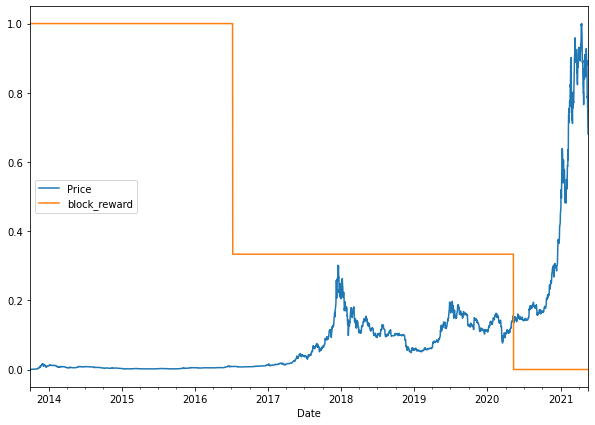

In [53]:
# Plot the block reward vs price over time using minmax scale to rescale the values
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import minmax_scale

scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset using pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above. However, since we've now got multivariate data, these functions won't work. Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data.

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

In [54]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [55]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)

In [56]:
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas DataFrame.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [57]:
# Create X (windows) and y (horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [58]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [59]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense model with multivariate data

In [60]:
tf.random.set_seed(42)

# Build a simple dense model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_6_dense_multivariate_data")

model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

model_6.fit(x=X_train,
            y=y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
18/18 [==============================] - 2s 92ms/step - loss: 1234.6804 - mae: 1234.6804 - mse: 5282005.5000 - val_loss: 2061.8840 - val_mae: 2061.8840 - val_mse: 11377552.0000
Epoch 2/100
18/18 [==============================] - 0s 28ms/step - loss: 351.5053 - mae: 351.5053 - mse: 499358.0312 - val_loss: 1908.6816 - val_mae: 1908.6816 - val_mse: 8719460.0000
Epoch 3/100
18/18 [==============================] - 1s 29ms/step - loss: 235.4153 - mae: 235.4153 - mse: 276006.8125 - val_loss: 1329.0612 - val_mae: 1329.0612 - val_mse: 4991874.0000
Epoch 4/100
18/18 [==============================] - 1s 29ms/step - loss: 208.6112 - mae: 208.6112 - mse: 219502.7188 - val_loss: 1102.1311 - val_mae: 1102.1311 - val_mse: 3934647.2500
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 196.5770 - mae: 196.5770 - mse: 204309.3750 - val_loss: 1107.8501 - val_mae: 1107.8501 - val_mse: 3822055.5000
Epoch 6/100
18/18 [==============================] - 1s 29ms/step - loss

In [61]:
# Load best performing model_6 and evaluate on test data
model_6 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_data")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 567.8910 - mae: 567.8910 - mse: 1164817.6250


[567.8909912109375, 567.8909912109375, 1164817.625]

In [62]:
# Make predictions and view results
model_6_preds = make_preds(model_6, X_test)
model_6_results = evaluate_preds(y_true=tf.squeeze(y_test), y_pred=model_6_preds)
model_6_results

{'mae': 567.8909,
 'mape': 2.5460868,
 'mase': 0.9976271,
 'mse': 1164817.6,
 'rmse': 1079.2671}

In [63]:
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4711}

## Model 7: N-BEATS algorithm

Let's now try build the biggest time series forecasting model we've built so far. More specifically, we're going to be replicating the alogrithm in the following paper (Fig 1): https://arxiv.org/abs/1905.10437

Why?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing to make our own custom layers
* Get experience using the Functional API to create a custom architecture.
* Potentially get state of the art results on our problem.

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it. To create custom layers and models in TensorFlow, we can use subclassing: https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [ ]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all the arguments for the parent class (input_shape, trainable, etc.)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers, each with ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]

    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output the backcast and the forecast
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    
    return backcast, forecast

Let's test our NBeatsBlock class. To do so, we'll make some dummy inputs and outputs

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # WINDOW_SIZE is backcast, HORIZON is forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy_inputs to dummy_NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.07960171  0.32512033 -0.8428683  -0.6938985  -0.31720552 -0.5698734
 -0.6396662 ]
Forecast: 1.0071648359298706


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible, we're going to be adhering to the performance data pipeline steps in the `tf.data` guide: https://www.tensorflow.org/guide/data_performance

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Create NBEATS data inputs (N-BEATS work with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()

for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)

bitcoin_prices_nbeats.head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# Time to make our dataset performant using tf.data API
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (features, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

The N-BEATS algoirthme has a fair few numbe of parameters, many of them can be found in Table 18: https://arxiv.org/abs/1905.10437

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we can craft our N-BEATS model, we need two layers for the residual connections ([subtract](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Subtract) and [add](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add)).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-BEATS paper).

For more on residual connections, see: https://en.wikipedia.org/wiki/Residual_neural_network and https://paperswithcode.com/method/resnet.

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
addded = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {addded.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS alogrithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this will be the initial block used for the network, then the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecast for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it in-line with our other models) and Adam optimizer with default setting as per section 5.2 of the N-BEATS paper
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
  * Reduce LR on Platuea - if a model stops improving, try lowering the learning rate to reduce the amount it updates it weights each time (take smaller steps towards best performance)

In [ ]:
%%time
tf.random.set_seed(42)

# 1. Setup instance of NBeatsBlock layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE, # WINDOW_SIZE is backcast, HORIZON is forecast
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create an input layer
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Make the initial backcast and forecast input for the model
residuals, forecast = nbeats_block_layer(stack_input)

# 4. Use for loop to create stacks of block layers
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already created in (3)

  # 5. Use the NBeatsBlock to calculate backcast and forecast
  backcast, block_forecast = NBeatsBlock(input_size=INPUT_SIZE,
                                         theta_size=THETA_SIZE,
                                         horizon=HORIZON,
                                         n_neurons=N_NEURONS,
                                         n_layers=N_LAYERS,
                                         name=f"NBeatsBlock_{i}")(residuals) # pass in the residuals
  
  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, outputs=forecast, name="model_7_NBEATS")

# 8. Compile the model with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# 9. Fit the model with EarlyStopping and ReducedLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                        patience=200,
                                                        restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                            patience=100,
                                                            verbose=1)])


Epoch 768: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1109: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 3min 18s, sys: 5.72 s, total: 3min 24s
Wall time: 4min 26s


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 24ms/step - loss: 572.8341


572.8341064453125

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8830.621, 8779.281, 9048.381, 8750.873, 8750.176, 8752.562,
       8663.368, 8496.158, 8477.693, 8521.02 ], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model preds
model_7_results = evaluate_preds(y_true=y_test, y_pred=model_7_preds)
model_7_results

{'mae': 572.8341,
 'mape': 2.5993414,
 'mase': 1.0063108,
 'mse': 1167105.6,
 'rmse': 1080.3267}

In [ ]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171743.8,
 'rmse': 1082.4711}

> Even with all of those special layers and hand-crafted network, it looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast. This goes to show the power of smaller networks as well as the fact that not all larger models are better suited for a certain type of data.

### Plotting the N-BEATS architecture we've created

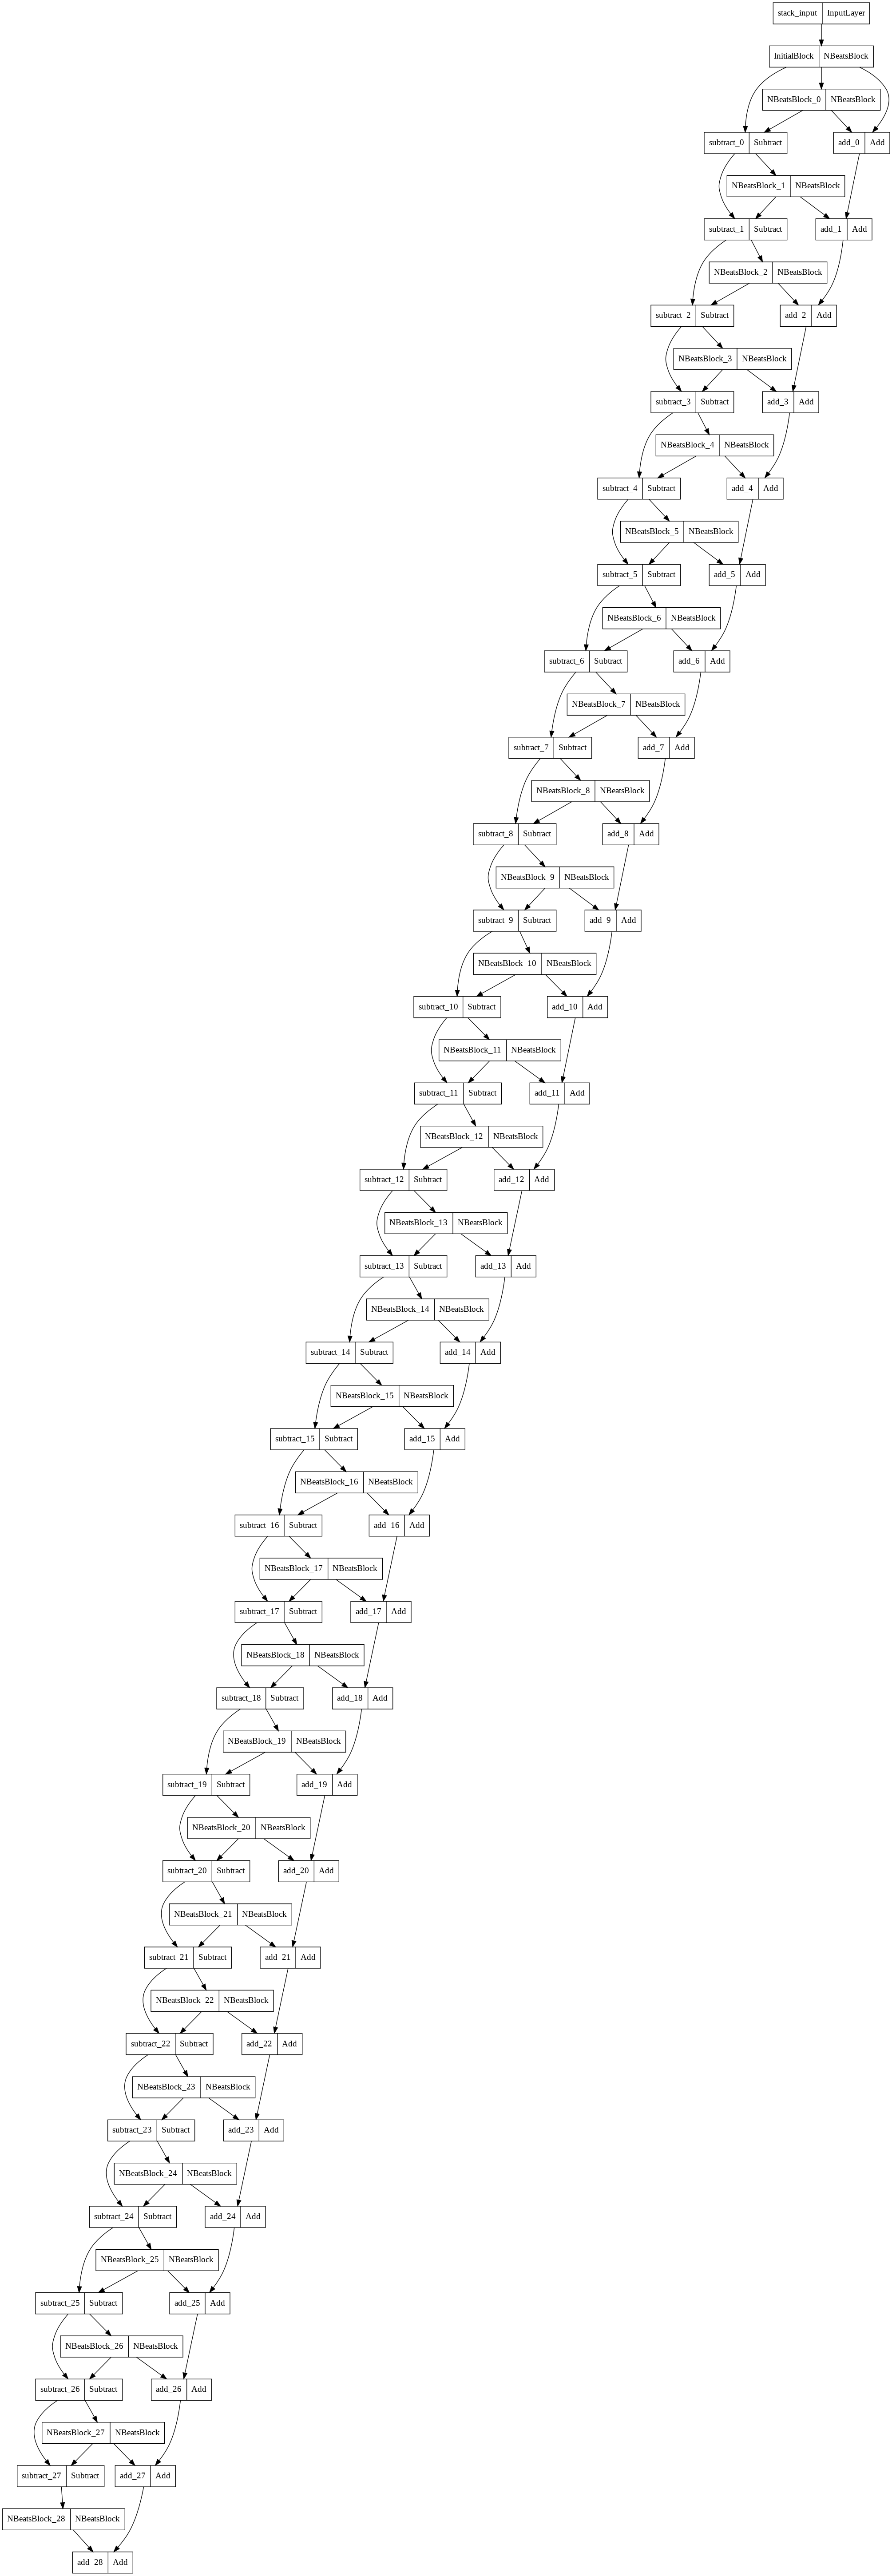

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together)

An ensemble leverages the wisdom of the crowd effect. It combines many *different* models to predict a common goal.

### Constructing and fitting an ensemble of models (using different loss functions)

In [ ]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=1000,
                        loss_fns=["mae", "mse", "mape"]):
  
  """
  Returns a list of num_iter models each trained on MAE, MSE, and MAPE loss.

  For example, if num_iter = 10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
        # Initialize dense layers with normal distribution for estimating prediction intervals later on
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
        layers.Dense(HORIZON, activation="linear")
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit the current model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models


In [ ]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 499: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 168: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 268: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 910: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 419: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 519: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 177: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 949: ReduceLROnPlateau reduci

In [ ]:
len(ensemble_models)

15

### Make predictions with our ensemble model

In [ ]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  
  ensemble_preds = []

  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)

  return tf.constant(tf.squeeze(ensemble_preds))

In [ ]:
# Create a list of ensemble predictions
%%time
ensemble_preds = make_ensemble_preds(ensemble_models, test_dataset)

CPU times: user 907 ms, sys: 24 ms, total: 931 ms
Wall time: 999 ms


In [ ]:
ensemble_preds

<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8811.226 ,  8817.694 ,  9110.956 , ..., 50951.8   , 50266.332 ,
        46894.59  ],
       [ 8738.032 ,  8723.02  ,  9039.4375, ..., 49308.53  , 48636.418 ,
        45488.24  ],
       [ 8745.424 ,  8733.034 ,  9101.386 , ..., 49267.164 , 47660.426 ,
        45370.047 ],
       ...,
       [ 8959.8125,  8792.332 ,  9064.699 , ..., 49558.45  , 49947.223 ,
        46725.21  ],
       [ 8725.752 ,  8803.012 ,  9100.014 , ..., 49578.895 , 48514.516 ,
        45046.312 ],
       [ 8819.377 ,  8762.986 ,  9041.4   , ..., 49739.227 , 48085.863 ,
        45842.387 ]], dtype=float32)>

> Our ensemble predictions come out in multiple dimensions, but to combine into **point predictions**, we can leverage the mean / median of all the predictions - https://machinelearningmastery.com/combine-predictions-for-ensemble-learning/

In [ ]:
# Get mean of predictions
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8794.714, 8782.587, 9069.503, 8731.647, 8749.591, 8712.835,
       8673.319, 8480.438, 8457.622, 8529.202], dtype=float32)>

In [ ]:
# Get median of predictions
import numpy as np
ensemble_median = tf.constant(np.median(ensemble_preds, axis=0))
ensemble_median[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8788.138, 8777.582, 9064.699, 8722.22 , 8746.119, 8725.742,
       8672.572, 8478.286, 8457.571, 8530.542], dtype=float32)>

In [ ]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds)
ensemble_mean_results = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)
ensemble_median_results = evaluate_preds(y_true=y_test, y_pred=ensemble_median)

print(f"Ensemble predictions results: {ensemble_results}\n")
print(f"Ensemble predictions mean results: {ensemble_mean_results}\n")
print(f"Ensemble predictions median results: {ensemble_median_results}")

Ensemble predictions results: {'mae': 579.9556, 'mse': 1185158.4, 'rmse': 1088.4286, 'mape': 2.6563432, 'mase': 1.0188214}

Ensemble predictions mean results: {'mae': 567.17236, 'mse': 1146143.1, 'rmse': 1070.5807, 'mape': 2.580511, 'mase': 0.9963648}

Ensemble predictions median results: {'mae': 566.5185, 'mse': 1142928.6, 'rmse': 1069.0784, 'mape': 2.5796027, 'mase': 0.9952161}


### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models. However, it would be more helpful to know a range of where that prediction comes from. One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian / Normal, 95% of observations fall within 1.96 standard deviation of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean / median of the predictions made in (1).

https://eng.uber.com/neural-networks-uncertainty-estimation/

In [ ]:
# Find upper and lower bounds of ensemble predictions

# 1. Take the predictions from a number of randomly initialized models
def get_upper_lower(preds):

  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)

  # 3. Multiply the standard deviation by 1.96
  interval = std * 1.96

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.math.reduce_mean(preds, axis=0)
  lower_bound = preds_mean - interval
  upper_bound = preds_mean + interval

  return lower_bound, upper_bound 

In [ ]:
# Get upper and lower bounds of the 95% prediction interval
lower, upper = get_upper_lower(ensemble_preds)

> **Note:** Many of the steps we've taken above have been inspired / referenced from the Machine Learning Mastery blog post on [Prediction Intervals for Deep Learning Neural Networks](https://machinelearningmastery.com/prediction-intervals-for-deep-learning-neural-networks/)

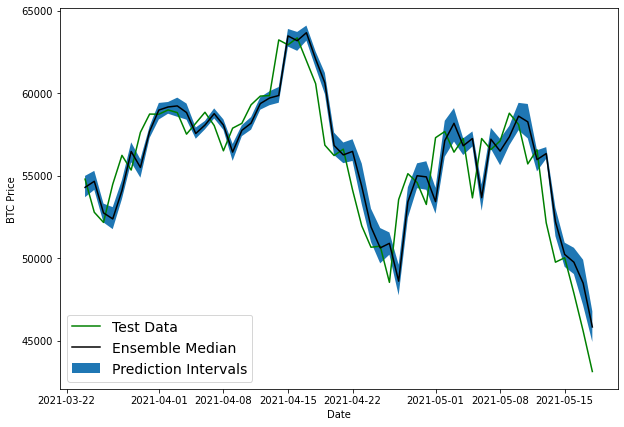

In [ ]:
# Get the mean / median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")

# To plot the upper and lower bounds let's use fill_between: https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.fill_between.html
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:],
                 label="Prediction Intervals")
plt.legend(loc="lower left", fontsize=14);

So far, all of our model's predictions have been lagging behind the test data, as in they're replicating what the naive model does and just predict the previous timestep as the next timestep.

> **Note:** These prediction intervals are estimates themselves, And they have been created with the assumption that our model's data is from a normal distribution.

## Aside: two types of uncertainty (coconut and subway)

Uncertain estimates in machine learning seek out to qualitatively and quantitatively answer the questions:
1. What can my model know? (with perfect data, what's possible for a model to learn?)
2. What doesn't my model know? (what can a model never predict? or would it be helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are 2 major types of uncertainty in machine learning:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred to as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty

When measuring prediction intervals, we're estimating a form of aleatoric uncertainty.

To learn more about uncertainty in machine learning:
* [MIT 6.S191: Evidential Deep Learning and Uncertainty](https://youtu.be/toTcf7tZK8c)
* [Why you should care about the Nate Silver vs. Nassim Taleb Twitter war](https://towardsdatascience.com/why-you-should-care-about-the-nate-silver-vs-nassim-taleb-twitter-war-a581dce1f5fc)
* [3 facts about time series forecasting that surprise experienced machine learning practitioners](https://towardsdatascience.com/3-facts-about-time-series-forecasting-that-surprise-experienced-machine-learning-practitioners-69c18ee89387)
* [Engineering Uncertainty Estimation in Neural Networks for Time Series Prediction at Uber](https://eng.uber.com/neural-networks-uncertainty-estimation/)

## Model 9: Train a model on the full historical data to make predictions into the future

So far all of our models have predicted on the test dataset, however, this is only a pseudofuture. Let's now build a model which is capable of predicting into the future!

In [ ]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Train model on entire data to make predictions for the next day
X_all = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).to_numpy()

# Get labels
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

len(X_all), len(y_all)

(2780, 2780)

In [ ]:
# Turn data into efficient running tensors
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [ ]:
tf.random.set_seed(42)

# Build a model that trains on all of the data and can predict into the future
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_9_future_model")

model_9.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_9.fit(dataset_all,
            epochs=100,
            verbose=1,
            callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/tensorflow/timeseries/model_experiments/" + model_9.name,
                                                          monitor="loss",
                                                          verbose=0,
                                                          save_best_only=True)])

Epoch 1/100
1/3 [=========>....................] - ETA: 1s - loss: 372.9943INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 437ms/step - loss: 4310.6460
Epoch 2/100
1/3 [=========>....................] - ETA: 0s - loss: 217.6988INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 667ms/step - loss: 2286.0432
Epoch 3/100
1/3 [=========>....................] - ETA: 0s - loss: 86.5396INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 402ms/step - loss: 455.6416
Epoch 4/100
3/3 [==============================] - 0s 7ms/step - loss: 1394.4469
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 1358.7922
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 600.7654
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 584.5320
Epoch 8/100
3/3 [==============================] - 0s 8ms/step - loss: 817.2908
Epoch 9/100
3/3 [==============================] - 0s 8ms/step - loss: 534.2358
Epoch 10/100
1/3 [=========>....................] - ETA: 0s - loss: 20.8263INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 441ms/step - loss: 394.9994
Epoch 11/100
3/3 [==============================] - 0s 9ms/step - loss: 524.4480
Epoch 12/100
1/3 [=========>....................] - ETA: 0s - loss: 32.8315INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 433ms/step - loss: 370.9251
Epoch 13/100
3/3 [==============================] - 0s 9ms/step - loss: 413.3246
Epoch 14/100
3/3 [==============================] - 0s 9ms/step - loss: 405.3439
Epoch 15/100
1/3 [=========>....................] - ETA: 0s - loss: 19.8148INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 416ms/step - loss: 338.5110
Epoch 16/100
3/3 [==============================] - 0s 10ms/step - loss: 372.8965
Epoch 17/100
1/3 [=========>....................] - ETA: 0s - loss: 22.7483INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 426ms/step - loss: 330.8933
Epoch 18/100
3/3 [==============================] - 0s 6ms/step - loss: 339.5727
Epoch 19/100
1/3 [=========>....................] - ETA: 0s - loss: 18.7310INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 406ms/step - loss: 318.8771
Epoch 20/100
3/3 [==============================] - 0s 7ms/step - loss: 324.4536
Epoch 21/100
3/3 [==============================] - 0s 8ms/step - loss: 319.4956
Epoch 22/100
1/3 [=========>....................] - ETA: 0s - loss: 18.3605INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 433ms/step - loss: 310.8959
Epoch 23/100
3/3 [==============================] - 0s 10ms/step - loss: 313.4972
Epoch 24/100
1/3 [=========>....................] - ETA: 0s - loss: 18.9438INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 422ms/step - loss: 309.3207
Epoch 25/100
1/3 [=========>....................] - ETA: 0s - loss: 18.1118INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 425ms/step - loss: 304.2360
Epoch 26/100
1/3 [=========>....................] - ETA: 0s - loss: 18.5410INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 429ms/step - loss: 303.8859
Epoch 27/100
1/3 [=========>....................] - ETA: 0s - loss: 18.2731INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 419ms/step - loss: 301.9947
Epoch 28/100
1/3 [=========>....................] - ETA: 0s - loss: 17.8405INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 436ms/step - loss: 298.0923
Epoch 29/100
1/3 [=========>....................] - ETA: 0s - loss: 18.1167INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 405ms/step - loss: 296.2786
Epoch 30/100
1/3 [=========>....................] - ETA: 0s - loss: 17.7359INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 414ms/step - loss: 294.1579
Epoch 31/100
1/3 [=========>....................] - ETA: 0s - loss: 17.7223INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 419ms/step - loss: 292.2020
Epoch 32/100
1/3 [=========>....................] - ETA: 0s - loss: 17.4956INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 414ms/step - loss: 290.6356
Epoch 33/100
1/3 [=========>....................] - ETA: 0s - loss: 17.3224INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 419ms/step - loss: 287.3443
Epoch 34/100
1/3 [=========>....................] - ETA: 0s - loss: 17.0571INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 728ms/step - loss: 285.8888
Epoch 35/100
1/3 [=========>....................] - ETA: 0s - loss: 16.7650INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 402ms/step - loss: 283.2659
Epoch 36/100
1/3 [=========>....................] - ETA: 0s - loss: 16.9697INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 436ms/step - loss: 280.7813
Epoch 37/100
1/3 [=========>....................] - ETA: 0s - loss: 16.4670INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 415ms/step - loss: 276.4138
Epoch 38/100
1/3 [=========>....................] - ETA: 0s - loss: 16.6585INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 426ms/step - loss: 274.8173
Epoch 39/100
1/3 [=========>....................] - ETA: 0s - loss: 16.3980INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 427ms/step - loss: 273.0920
Epoch 40/100
1/3 [=========>....................] - ETA: 0s - loss: 16.3735INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 454ms/step - loss: 272.6808
Epoch 41/100
1/3 [=========>....................] - ETA: 0s - loss: 16.2136INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 673ms/step - loss: 271.7675
Epoch 42/100
1/3 [=========>....................] - ETA: 0s - loss: 16.2084INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 423ms/step - loss: 267.9027
Epoch 43/100
1/3 [=========>....................] - ETA: 0s - loss: 15.7932INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 414ms/step - loss: 266.0061
Epoch 44/100
3/3 [==============================] - 0s 8ms/step - loss: 272.7340
Epoch 45/100
3/3 [==============================] - 0s 6ms/step - loss: 286.0580
Epoch 46/100
3/3 [==============================] - 0s 8ms/step - loss: 309.2220
Epoch 47/100
3/3 [==============================] - 0s 6ms/step - loss: 293.1663
Epoch 48/100
3/3 [==============================] - 0s 7ms/step - loss: 270.3433
Epoch 49/100
1/3 [=========>....................] - ETA: 0s - loss: 15.3760INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 401ms/step - loss: 255.0813
Epoch 50/100
1/3 [=========>....................] - ETA: 0s - loss: 15.5645INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 478ms/step - loss: 251.8032
Epoch 51/100
1/3 [=========>....................] - ETA: 0s - loss: 15.1381INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 735ms/step - loss: 248.7537
Epoch 52/100
1/3 [=========>....................] - ETA: 0s - loss: 15.2772INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 443ms/step - loss: 247.6945
Epoch 53/100
1/3 [=========>....................] - ETA: 0s - loss: 15.0633INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 427ms/step - loss: 247.1436
Epoch 54/100
1/3 [=========>....................] - ETA: 0s - loss: 15.0588INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 421ms/step - loss: 246.2417
Epoch 55/100
1/3 [=========>....................] - ETA: 0s - loss: 15.0176INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 425ms/step - loss: 244.9807
Epoch 56/100
1/3 [=========>....................] - ETA: 0s - loss: 14.9242INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 423ms/step - loss: 244.1710
Epoch 57/100
1/3 [=========>....................] - ETA: 0s - loss: 14.9284INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 420ms/step - loss: 242.4066
Epoch 58/100
1/3 [=========>....................] - ETA: 0s - loss: 14.8120INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 439ms/step - loss: 241.8420
Epoch 59/100
1/3 [=========>....................] - ETA: 0s - loss: 14.7903INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 415ms/step - loss: 240.6850
Epoch 60/100
3/3 [==============================] - 0s 9ms/step - loss: 241.2693
Epoch 61/100
3/3 [==============================] - 0s 10ms/step - loss: 248.1002
Epoch 62/100
3/3 [==============================] - 0s 9ms/step - loss: 292.4109
Epoch 63/100
3/3 [==============================] - 0s 7ms/step - loss: 376.4588
Epoch 64/100
3/3 [==============================] - 0s 7ms/step - loss: 319.5061
Epoch 65/100
3/3 [==============================] - 0s 9ms/step - loss: 263.8123
Epoch 66/100
3/3 [==============================] - 0s 8ms/step - loss: 245.3483
Epoch 67/100
3/3 [==============================] - 0s 9ms/step - loss: 242.0847
Epoch 68/100
3/3 [==============================] - 0s 6ms/step - loss: 249.4348
Epoch 69/100
3/3 [==============================] - 0s 9ms/step - loss: 273.9312
Epoch 70/100
3/3 [==============================] - 0s 10ms/step - loss: 304.3418
Epoch 71/100
3/3 [===================

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_9_future_model/assets


3/3 [==============================] - 1s 745ms/step - loss: 238.9451
Epoch 98/100
3/3 [==============================] - 0s 9ms/step - loss: 240.2160
Epoch 99/100
3/3 [==============================] - 0s 7ms/step - loss: 240.2108
Epoch 100/100
3/3 [==============================] - 0s 6ms/step - loss: 247.7011


### Make predictions into the future

For time series forecasts, you have to retrain a model every time you make a prediction. As new data comes in, retrain the model and make a prediction.

In [ ]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14

To make predictions into the future, we want a function which:

1. Takes as input:
  * a list of values (Bitcoin historical data)
  * a trained model (such as `model_9`)
  * a window into the future to predict (our `INTO_FUTURE` variable)
  * the window size a model was trained on (`WINDOW_SIZE`) - a model can only predict on the same kind of data it was trained on
2. Creates an empty list for future forecasts (this will be returned at the end of the function when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values
3. Loop `INTO_FUTURE` times, making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction


In [ ]:
# 1. Create a function to make predictions into the future
def make_future_forecasts(features, values, model, into_future=INTO_FUTURE, window_size=WINDOW_SIZE):

  """
  Make future forecasts into_future steps after values ends.

  Returns future forecasts as a list of floats.
  """

  # 2. Create an empty list for future forecasts / prepare data to forecast on
  future_forecasts = []
  last_window = values[-WINDOW_SIZE:]

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time
  for _ in range(INTO_FUTURE):

    # Predict on the last window then append it
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on:\n{last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecasts.append(tf.squeeze(future_pred).numpy())

    # Update last window with new pred and get WINDOW_SIZE most recent preds
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]

    # Update data to include new predictions
    last_features = np.insert(features[-1], 0, last_window[-1])[:WINDOW_SIZE]
    features = np.append(X_all, np.expand_dims(last_features, axis=0), axis=0)
    values = np.append(values, last_window[-1])

    features_dataset_new = tf.data.Dataset.from_tensor_slices(features)
    labels_dataset_new = tf.data.Dataset.from_tensor_slices(values)
    dataset_new = tf.data.Dataset.zip((features_dataset_new, labels_dataset_new))

    BATCH_SIZE = 1024
    dataset_new = dataset_new.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    # Retrain model
    model = retrain_model(dataset_new)
  
  return future_forecasts

> As an extension, try to make a prediction (one timestep into the future), retrain a model with this new prediction appended to the data, make a prediction, append the prediction, retrain the model... etc.

In [ ]:
def retrain_model(data):
  
  tf.random.set_seed(42)

  model = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
  ])

  model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam())

  model.fit(data,
            epochs=100,
            verbose=0)
  
  return model

In [ ]:
# Make forecasts into the future
future_forecast = make_future_forecasts(features=X_all, values=y_all, model=model_9)
future_forecast

Predicting on:
[56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55764.47265625

Predicting on:
[52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55764.47265625] -> Prediction: 51053.65625

Predicting on:
[49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55764.47265625 51053.65625   ] -> Prediction: 48578.0234375

Predicting on:
[50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55764.47265625 51053.65625    48578.0234375 ] -> Prediction: 48242.00390625

Predicting on:
[47885.62525472 45604.61575361 43144.47129086 55764.47265625
 51053.65625    48578.0234375  48242.00390625] -> Prediction: 47505.99609375

Predicting on:
[45604.61575361 43144.47129086 55764.47265625 51053.65625
 48578.0234375  48242.00390625 47505.99609375] -> Prediction: 46814.37890625

Predicting on:
[43144.47129086 55764.47265625 51053.65625    48578.0234375
 48242.0

[55764.473,
 51053.656,
 48578.023,
 48242.004,
 47505.996,
 46814.38,
 48491.84,
 53624.062,
 49184.0,
 47757.52,
 48235.43,
 48601.055,
 48621.367,
 49910.62]

### Plot future forecasts

In [ ]:
future_forecast

[55764.473,
 51053.656,
 48578.023,
 48242.004,
 47505.996,
 46814.38,
 48491.84,
 53624.062,
 49184.0,
 47757.52,
 48235.43,
 48601.055,
 48621.367,
 49910.62]

In [ ]:
def get_future_dates(start_date, into_future=INTO_FUTURE, offset=1):

  """
  Returns array of datetime values ranging from start_date to start_data + into_future.
  """

  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date

  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start and end date

In [ ]:
# Last timestep of timesteps (currently np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep

Timestamp('2021-05-18 00:00:00')

In [ ]:
# Get next 2 weeks of timesteps
next_timesteps = get_future_dates(start_date=last_timestep)
next_timesteps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [ ]:
# Inset last timestep / final price into next timesteps and future forecasts
next_timesteps_new = np.insert(next_timesteps, 0, last_timestep)
future_forecast_new = np.insert(future_forecast, 0, btc_price[-1])

next_timesteps_new, future_forecast_new

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55764.473, 51053.656, 48578.023, 48242.004, 47505.996,
        46814.38 , 48491.84 , 53624.062, 49184.   , 47757.52 , 48235.43 ,
        48601.055, 48621.367, 49910.62 ], dtype=float32))

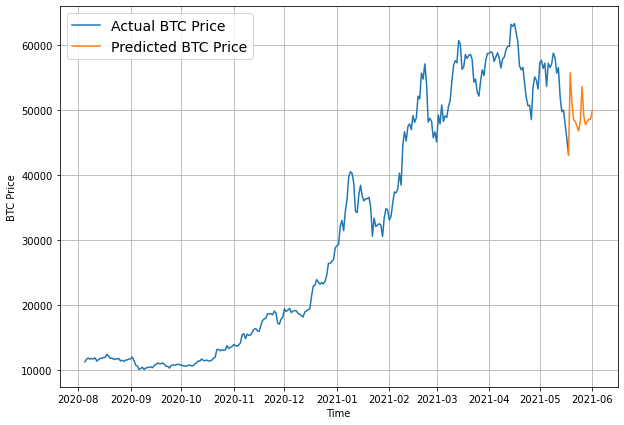

In [ ]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))

plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_timesteps_new, future_forecast_new, format="-", label="Predicted BTC Price")

## Model 10: The turkey problem

In [ ]:
# Let's introduce a turkey problem to our BTC data (price of BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [ ]:
# Manufacture an extra price on the end (to showcase our turkey problem)
btc_price_turkey[-10:]

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [ ]:
# Get the timesteps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

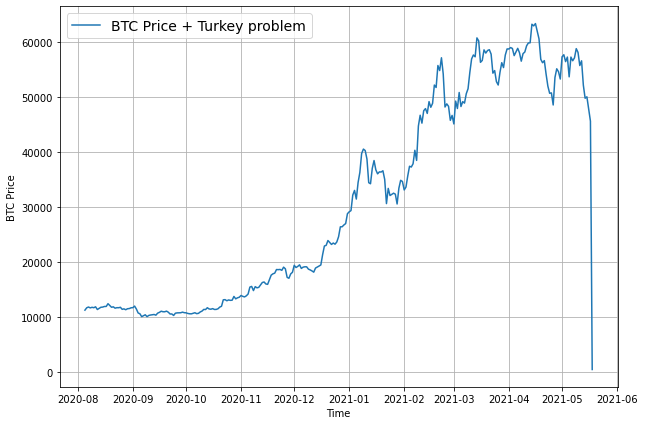

In [ ]:
# Plot the turkey problem
plt.figure(figsize=(10, 7))
plot_time_series(btc_timesteps_turkey, btc_price_turkey, start=2500, format="-", label="BTC Price + Turkey problem")

In [ ]:
# Create train and test sets for the turkey problem
full_windows_turkey, full_labels_turkey = make_windows(np.array(btc_price_turkey))
train_windows_turkey, test_windows_turkey, train_labels_turkey, test_labels_turkey = make_train_test_splits(full_windows_turkey, full_labels_turkey)

### Build a turkey model

In [ ]:
tf.random.set_seed(42)

# Build a simple dense model
model_10 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_10_turkey_problem")

model_10.compile(loss="mae",
                 optimizer=tf.keras.optimizers.Adam())

model_10.fit(x=train_windows_turkey,
             y=train_labels_turkey,
             epochs=100,
             verbose=1,
             batch_size=128,
             validation_data=(test_windows_turkey, test_labels_turkey),
             callbacks=[create_model_checkpoint(model_name=model_10.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 8s - loss: 2111.0571INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 51ms/step - loss: 780.3455 - val_loss: 2356.4749
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 264.2558INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 46ms/step - loss: 247.6756 - val_loss: 1082.8213
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 134.4855INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 44ms/step - loss: 188.4116 - val_loss: 1000.1082
Epoch 4/100
16/18 [=========================>....] - ETA: 0s - loss: 169.4214INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 42ms/step - loss: 169.4340 - val_loss: 977.4093
Epoch 5/100
15/18 [========================>.....] - ETA: 0s - loss: 168.5602INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 43ms/step - loss: 165.0894 - val_loss: 972.0458
Epoch 6/100
16/18 [=========================>....] - ETA: 0s - loss: 156.0607INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 44ms/step - loss: 158.5210 - val_loss: 932.0203
Epoch 7/100
15/18 [========================>.....] - ETA: 0s - loss: 155.5176INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 45ms/step - loss: 151.3566 - val_loss: 917.7386
Epoch 8/100
14/18 [======================>.......] - ETA: 0s - loss: 144.7855INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 44ms/step - loss: 145.2560 - val_loss: 880.4176
Epoch 9/100
14/18 [======================>.......] - ETA: 0s - loss: 140.2921INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 45ms/step - loss: 144.3546 - val_loss: 876.3675
Epoch 10/100
15/18 [========================>.....] - ETA: 0s - loss: 138.0327INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 45ms/step - loss: 141.2943 - val_loss: 840.3229
Epoch 11/100
18/18 [==============================] - 0s 7ms/step - loss: 135.6595 - val_loss: 848.1576
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 134.1700 - val_loss: 859.6298
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 134.6015 - val_loss: 861.2668
Epoch 14/100
16/18 [=========================>....] - ETA: 0s - loss: 127.6812INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 46ms/step - loss: 130.6127 - val_loss: 828.1453
Epoch 15/100
15/18 [========================>.....] - ETA: 0s - loss: 130.4053INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 44ms/step - loss: 128.8347 - val_loss: 773.3975
Epoch 16/100
18/18 [==============================] - 0s 6ms/step - loss: 124.7739 - val_loss: 779.2919
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 123.4474 - val_loss: 781.7458
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 137.2540INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 43ms/step - loss: 122.2105 - val_loss: 744.7944
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 121.7263 - val_loss: 795.7016
Epoch 20/100
15/18 [========================>.....] - ETA: 0s - loss: 120.0781INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 68ms/step - loss: 119.2420 - val_loss: 733.8886
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 124.6584INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 54ms/step - loss: 121.2275 - val_loss: 713.8552
Epoch 22/100
18/18 [==============================] - 0s 8ms/step - loss: 119.9544 - val_loss: 748.0707
Epoch 23/100
12/18 [===================>..........] - ETA: 0s - loss: 119.1282INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 46ms/step - loss: 121.9248 - val_loss: 710.1812
Epoch 24/100
 8/18 [============>.................] - ETA: 0s - loss: 113.3576INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 2s 97ms/step - loss: 116.3665 - val_loss: 701.3072
Epoch 25/100
16/18 [=========================>....] - ETA: 0s - loss: 117.2713INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 47ms/step - loss: 114.6816 - val_loss: 696.5790
Epoch 26/100
15/18 [========================>.....] - ETA: 0s - loss: 120.0187INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 47ms/step - loss: 116.4455 - val_loss: 692.4583
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 116.5868 - val_loss: 692.7849
Epoch 28/100
16/18 [=========================>....] - ETA: 0s - loss: 112.7727INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 44ms/step - loss: 113.4691 - val_loss: 684.9141
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 113.7598 - val_loss: 698.7525
Epoch 30/100
 1/18 [>.............................] - ETA: 0s - loss: 124.9585INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 45ms/step - loss: 116.8613 - val_loss: 681.2276
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 111.9375 - val_loss: 686.2102
Epoch 32/100
17/18 [===========================>..] - ETA: 0s - loss: 112.7391INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 2s 109ms/step - loss: 112.4175 - val_loss: 679.8808
Epoch 33/100
18/18 [==============================] - 0s 9ms/step - loss: 112.6697 - val_loss: 722.5193
Epoch 34/100
18/18 [==============================] - 0s 8ms/step - loss: 111.9867 - val_loss: 681.5853
Epoch 35/100
12/18 [===================>..........] - ETA: 0s - loss: 112.6920INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 52ms/step - loss: 110.9451 - val_loss: 670.2868
Epoch 36/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4816 - val_loss: 684.8294
Epoch 37/100
18/18 [==============================] - 0s 6ms/step - loss: 110.2016 - val_loss: 674.0528
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 112.2372 - val_loss: 714.8018
Epoch 39/100
16/18 [=========================>....] - ETA: 0s - loss: 116.8452INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 44ms/step - loss: 115.1289 - val_loss: 664.2899
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 110.0854 - val_loss: 669.5338
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 110.6344 - val_loss: 670.7217
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 113.5762 - val_loss: 713.1893
Epoch 43/100
18/18 [==============================] - 0s 7ms/step - loss: 116.2285 - val_loss: 739.7482
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 120.0192 - val_loss: 712.4581
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9675 - val_loss: 678.8146
Epoch 46/100
18/18 [==============================] - 0s 6ms/step - loss: 111.6012 - val_loss: 670.1751
Epoch 47/100
18/18 [==============================] - 0s 6ms/step - loss: 109.6161 - val_loss: 713.8232
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 10

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 43ms/step - loss: 112.4355 - val_loss: 656.5261
Epoch 50/100
18/18 [==============================] - 0s 6ms/step - loss: 110.2108 - val_loss: 716.0546
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0958 - val_loss: 674.1791
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7351 - val_loss: 657.5447
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 111.1785 - val_loss: 725.1806
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 114.0831 - val_loss: 670.0225
Epoch 55/100
15/18 [========================>.....] - ETA: 0s - loss: 114.3634INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 45ms/step - loss: 110.4910 - val_loss: 656.3287
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 108.0488 - val_loss: 884.2072
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 125.0614 - val_loss: 750.9877
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 115.4340 - val_loss: 659.0917
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 110.0881 - val_loss: 683.5860
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 108.7156 - val_loss: 679.1318
Epoch 61/100
14/18 [======================>.......] - ETA: 0s - loss: 108.0080INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 45ms/step - loss: 108.1525 - val_loss: 650.8209
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3726 - val_loss: 658.5235
Epoch 63/100
18/18 [==============================] - 0s 6ms/step - loss: 110.7667 - val_loss: 714.3463
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 110.1539 - val_loss: 663.4818
Epoch 65/100
18/18 [==============================] - ETA: 0s - loss: 108.2325INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 46ms/step - loss: 108.2325 - val_loss: 650.3839
Epoch 66/100
17/18 [===========================>..] - ETA: 0s - loss: 108.8999INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 43ms/step - loss: 108.6825 - val_loss: 649.0426
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 106.6371 - val_loss: 723.4578
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 114.1603 - val_loss: 758.6793
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 124.5514 - val_loss: 732.8113
Epoch 70/100
18/18 [==============================] - 0s 6ms/step - loss: 125.0234 - val_loss: 677.8259
Epoch 71/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3652 - val_loss: 672.2177
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9285 - val_loss: 650.5305
Epoch 73/100
18/18 [==============================] - 0s 6ms/step - loss: 109.5085 - val_loss: 657.2404
Epoch 74/100
18/18 [==============================] - 0s 6ms/step - loss: 108.7380 - val_loss: 652.9435
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 10

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 42ms/step - loss: 107.5879 - val_loss: 648.7521
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 108.1598 - val_loss: 652.0607
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 107.9175 - val_loss: 694.1303
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 108.9510 - val_loss: 660.3061
Epoch 81/100
16/18 [=========================>....] - ETA: 0s - loss: 105.9904INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 47ms/step - loss: 106.0505 - val_loss: 646.9022
Epoch 82/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6827 - val_loss: 652.5607
Epoch 83/100
18/18 [==============================] - 0s 6ms/step - loss: 110.9379 - val_loss: 736.4799
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 111.4836 - val_loss: 647.0178
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 107.5949 - val_loss: 678.4158
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 108.9425 - val_loss: 669.6321
Epoch 87/100
18/18 [==============================] - 0s 7ms/step - loss: 105.7717 - val_loss: 680.4393
Epoch 88/100
16/18 [=========================>....] - ETA: 0s - loss: 110.1163INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 45ms/step - loss: 107.9217 - val_loss: 645.8719
Epoch 89/100
15/18 [========================>.....] - ETA: 0s - loss: 99.8452 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem/assets


18/18 [==============================] - 1s 44ms/step - loss: 106.0344 - val_loss: 645.7731
Epoch 90/100
18/18 [==============================] - 0s 6ms/step - loss: 105.4977 - val_loss: 658.5897
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 108.8468 - val_loss: 650.4244
Epoch 92/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8884 - val_loss: 653.6464
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 113.8781 - val_loss: 685.1242
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5763 - val_loss: 678.4261
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 106.5906 - val_loss: 647.1871
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 116.9515 - val_loss: 692.0804
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 108.0739 - val_loss: 657.1296
Epoch 98/100
18/18 [==============================] - 0s 7ms/step - loss: 10

In [ ]:
# Load in saved best performing model_10 and evaluate it on test_data
model_10 = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_10_turkey_problem")
model_10.evaluate(test_windows_turkey, test_labels_turkey)

18/18 [==============================] - 0s 2ms/step - loss: 645.7731


645.7730712890625

In [ ]:
# Make predictions and view results
model_10_preds = make_preds(model_10, test_windows_turkey)
model_10_results = evaluate_preds(y_true=test_labels_turkey, y_pred=model_10_preds)
model_10_results

{'mae': 17125.525,
 'mape': 121.308525,
 'mase': 26.501806,
 'mse': 614164860.0,
 'rmse': 23707.303}

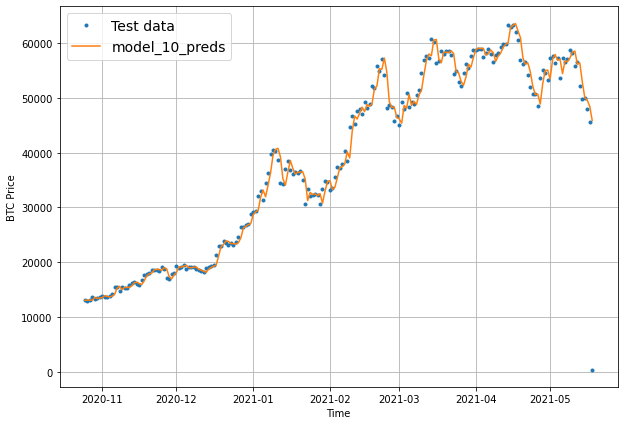

In [ ]:
# Plot model_10 predictions
offset = 350
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=btc_timesteps_turkey[-len(test_windows_turkey):],
                 values=btc_price_turkey[-len(test_labels_turkey):],
                 start=offset,
                 label="Test data")
plot_time_series(timesteps=btc_timesteps_turkey[-len(test_windows_turkey):],
                 values=model_10_preds,
                 start=offset,
                 format="-",
                 label="model_10_preds")

## Comparing models

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
all_model_results = pd.DataFrame({"naive_model": naive_results,
                                  "model_1_dense_w7_h1": model_1_results,
                                  "model_2_dense_w30_h1": model_2_results,
                                  "model_3_dense_w30_h7": model_3_results,
                                  "model_4_conv1D": model_4_results,
                                  "model_5_LSTM": model_5_results,
                                  "model_6_multivariate": model_6_results,
                                  "model_7_NBEATS": model_7_results,
                                  "model_8_ensemble": ensemble_median_results,
                                  "model_10_turkey": model_10_results}).transpose()

all_model_results

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,568.951111,1.171744e+06,1082.471069,2.544898,0.999490
model_2_dense_w30_h1,605.874084,1.273361e+06,1128.432861,2.726445,1.059074
model_3_dense_w30_h7,1237.506348,5.405198e+06,1425.747681,5.558878,2.202073
model_4_conv1D,570.738770,1.183500e+06,1087.887817,2.546120,1.002630
model_5_LSTM,594.602966,1.267232e+06,1125.713867,2.671757,1.044553
model_6_multivariate,567.890930,1.164818e+06,1079.267090,2.546087,0.997627
model_7_NBEATS,572.834106,1.167106e+06,1080.326660,2.599341,1.006311
model_8_ensemble,566.518494,1.142929e+06,1069.078369,2.579603,0.995216
model_10_turkey,17125.525391,6.141649e+08,23707.302734,121.308525,26.501806


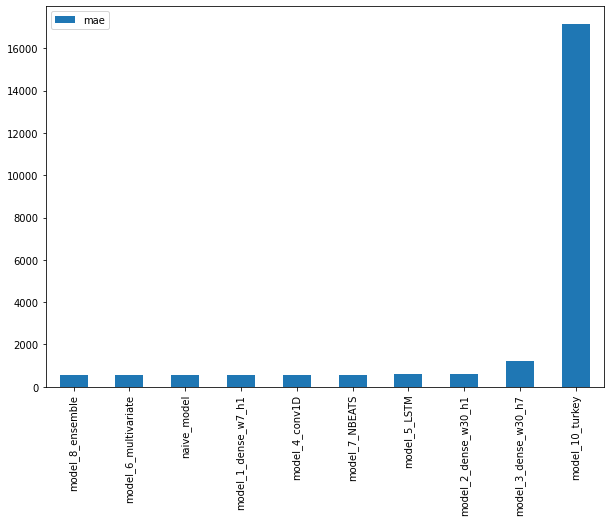

In [ ]:
# Sort model results by MAE and plot them
all_model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

# Exercises

## Exercise 1

Does scaling the data help for univariate / multivaraite data? (e.g. 
getting all of the values between 0 & 1)
* Try doing this for a univariate model (`model_1`) and a multivariate model (`model_6`) and see if it affects model training or evaluation results.

In [69]:
HORIZON = 1
WINDOW_SIZE = 7

In [67]:
# Scaling univariate data
btc_price_uni_scaled = bitcoin_prices.copy()
btc_price_uni_scaled["Price"] = btc_price_uni_scaled["Price"] / np.max(btc_price_uni_scaled["Price"])
btc_price_uni_scaled

,Price
Date,
2013-10-01,0.001952
2013-10-02,0.001980
2013-10-03,0.001714
2013-10-04,0.001873
2013-10-05,0.001915
...,...
2021-05-14,0.785583
2021-05-15,0.789822
2021-05-16,0.755928


In [73]:
# Formatting data
timesteps = btc_price_uni_scaled.index.to_numpy()
uni_price_scaled = btc_price_uni_scaled["Price"].to_numpy()

full_windows_uni_scaled, full_labels_uni_scaled = make_windows(uni_price_scaled)
train_windows_uni_scaled, test_windows_uni_scaled, train_labels_uni_scaled, test_labels_uni_scaled = make_train_test_splits(full_windows_uni_scaled, full_labels_uni_scaled)

In [89]:
# Recreate model_1
tf.random.set_seed(42)

model_1_scaled = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense_scaled")

model_1_scaled.compile(loss="mae",
                       optimizer=tf.keras.optimizers.Adam())

model_1_scaled.fit(x=train_windows_uni_scaled,
                   y=train_labels_uni_scaled,
                   epochs=100,
                   verbose=0,
                   batch_size=128,
                   validation_data=(test_windows_uni_scaled, test_labels_uni_scaled),
                   callbacks=[create_model_checkpoint(model_name=model_1_scaled.name)])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled

In [90]:
# Load in saved best performing model
model_1_scaled = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dense_scaled")
model_1_scaled.evaluate(test_windows_uni_scaled, test_labels_uni_scaled)

18/18 [==============================] - 0s 3ms/step - loss: 0.0091


0.009076383896172047

In [91]:
# Make predictions and view results
model_1_scaled_preds = make_preds(model_1_scaled, test_windows_uni_scaled)
model_1_scaled_results = evaluate_preds(y_true=tf.squeeze(test_labels_uni_scaled),
                                        y_pred=model_1_scaled_preds)
model_1_scaled_results

{'mae': 0.009076384,
 'mape': 2.5699856,
 'mase': 1.0100449,
 'mse': 0.00029909666,
 'rmse': 0.01729441}

In [93]:
model_1_results

{'mae': 568.95105,
 'mape': 2.5448983,
 'mase': 0.9994894,
 'mse': 1171743.8,
 'rmse': 1082.4711}

In [83]:
# Scaling multivariate data
btc_price_multi_scaled = bitcoin_prices_block.copy()
btc_price_multi_scaled["Price"] = btc_price_multi_scaled["Price"] / np.max(btc_price_multi_scaled["Price"])
btc_price_multi_scaled

,Price,block_reward
Date,,
2013-10-01,0.001952,25
2013-10-02,0.001980,25
2013-10-03,0.001714,25
2013-10-04,0.001873,25
2013-10-05,0.001915,25
...,...,...
2021-05-14,0.785583,6.25
2021-05-15,0.789822,6.25
2021-05-16,0.755928,6.25


In [88]:
# Make windowed dataset
btc_price_windowed_multi_scaled = btc_price_multi_scaled.copy()

for i in range(WINDOW_SIZE):
  btc_price_windowed_multi_scaled[f"Price+{i+1}"] = btc_price_windowed_multi_scaled["Price"].shift(periods=i+1)

full_windows_multi_scaled = btc_price_windowed_multi_scaled.dropna().drop("Price", axis=1).astype(np.float32)
full_labels_multi_scaled = btc_price_windowed_multi_scaled.dropna()["Price"].astype(np.float32)

train_windows_multi_scaled, test_windows_multi_scaled, train_labels_multi_scaled, test_labels_multi_scaled = make_train_test_splits(full_windows_multi_scaled, full_labels_multi_scaled)

In [94]:
# Recreate model_6
tf.random.set_seed(42)

model_6_scaled = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_6_dense_multivariate_scaled")

model_6_scaled.compile(loss="mae",
                       optimizer=tf.keras.optimizers.Adam())

model_6_scaled.fit(x=train_windows_multi_scaled,
                   y=train_labels_multi_scaled,
                   epochs=100,
                   verbose=0,
                   batch_size=128,
                   validation_data=(test_windows_multi_scaled, test_labels_multi_scaled),
                   callbacks=[create_model_checkpoint(model_name=model_6_scaled.name)])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled/assets
INFO:tensorflow:Assets writ

In [95]:
# Load in saved best performing model
model_6_scaled = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_dense_multivariate_scaled")
model_6_scaled.evaluate(test_windows_multi_scaled, test_labels_multi_scaled)

18/18 [==============================] - 0s 3ms/step - loss: 0.0151


0.015123684890568256

In [96]:
# Make predictions and view results
model_6_scaled_preds = make_preds(model_6_scaled, test_windows_multi_scaled)
model_6_scaled_results = evaluate_preds(tf.squeeze(test_labels_multi_scaled), model_6_scaled_preds)
model_6_scaled_results

{'mae': 0.015123685,
 'mape': 4.409043,
 'mase': 1.6830051,
 'mse': 0.0007917299,
 'rmse': 0.028137695}

In [97]:
model_6_results

{'mae': 567.8909,
 'mape': 2.5460868,
 'mase': 0.9976271,
 'mse': 1164817.6,
 'rmse': 1079.2671}

Scaling univariate and multivariate data does not improve the evaluation results of the models.

## Exercise 2

Get the most up to date data on Bitcoin, train a model & see how it goes.

Yahoo Finance: https://finance.yahoo.com/quote/BTC-USD/history

In [107]:
# Latest data is 25 May 2022
import pandas as pd

df=pd.read_csv("/content/BTC-USD.csv",
               parse_dates=["Date"],
               index_col=["Date"])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [111]:
# Get closing prices
bitcoin_prices_latest = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
bitcoin_prices_latest

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2022-05-21,29432.226563
2022-05-22,30323.722656
2022-05-23,29098.910156


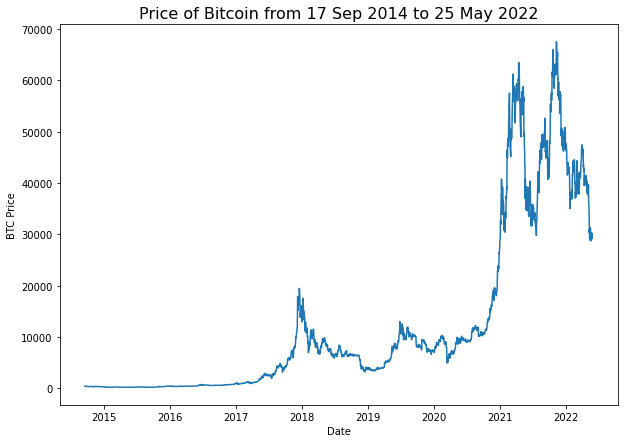

In [120]:
# Plot from CSV
plt.figure(figsize=(10, 7))
plt.plot(bitcoin_prices_latest.index.to_numpy(), bitcoin_prices_latest["Price"].to_numpy())
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 17 Sep 2014 to 25 May 2022", fontsize=16);

In [112]:
# Get Bitcoin date array
timesteps_latest = bitcoin_prices_latest.index.to_numpy()
prices_latest = bitcoin_prices_latest["Price"].to_numpy()

# Get windowed datasets
full_windows_latest, full_labels_latest = make_windows(prices_latest)

# Create train and test windows
train_windows_latest, test_windows_latest, train_labels_latest, test_labels_latest = make_train_test_splits(full_windows_latest, full_labels_latest)

In [116]:
# Train the latest data on model_1
tf.random.set_seed(42)

model_latest = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_latest_data")

model_latest.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())

model_latest.fit(x=train_windows_latest,
                 y=train_labels_latest,
                 epochs=100,
                 verbose=0,
                 batch_size=128,
                 validation_data=(test_windows_latest, test_labels_latest),
                 callbacks=[create_model_checkpoint(model_latest.name)])

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data/assets
INFO:tensorflow:

In [117]:
# Load in saved best performing model
model_latest = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_latest_data")
model_latest.evaluate(test_windows_latest, test_labels_latest)

18/18 [==============================] - 0s 3ms/step - loss: 1241.8948


1241.894775390625

In [118]:
# Make predictions and view results
model_latest_preds = make_preds(model_latest, test_windows_latest)
model_latest_results = evaluate_preds(tf.squeeze(test_labels_latest), model_latest_preds)
model_latest_results

{'mae': 1241.8948,
 'mape': 2.9554129,
 'mase': 1.006917,
 'mse': 2940080.8,
 'rmse': 1714.6664}

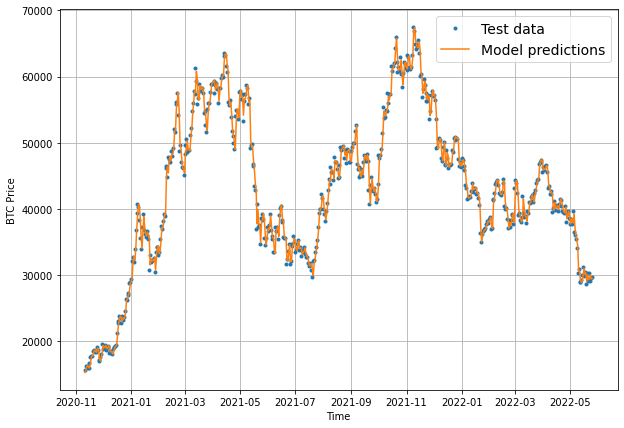

In [127]:
# Plot model predictions
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=timesteps_latest[-len(test_windows_latest):],
                 values=test_labels_latest[:, 0],
                 label="Test data")
plot_time_series(timesteps=timesteps_latest[-len(test_windows_latest):],
                 values=model_latest_preds,
                 format="-",
                 label="Model predictions")

## Exercise 3

Set up a series of experiments to find whether or not there's a better window size than `WINDOW_SIZE=7`. For example, you might train 10 different models with `HORIZON=1` but with window sizes ranging from 2-12.

We will use the same dates and prices as the ones used in `model_1`, and we will train the data on `model_1`.

In [133]:
HORIZON = 1

In [144]:
# Create a function to train different models with varying window sizes
def vary_window_size(first_window_size, last_window_size, x):

  for i in range(first_window_size, last_window_size + 1):
    print(f"Window size: {i}")

    # Create datasets
    full_windows, full_labels = make_windows(x, window_size=i, horizon=HORIZON)
    train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

    # Build, compile and fit model
    model = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(HORIZON, activation="linear")
    ], name="model_vary_window_size")

    model.compile(loss="mae",
                  optimizer=tf.keras.optimizers.Adam())
    
    model.fit(x=train_windows,
              y=train_labels,
              epochs=100,
              verbose=0,
              batch_size=128,
              validation_data=(test_windows, test_labels),
              callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="/content/drive/MyDrive/tensorflow/timeseries/model_experiments/" + model.name,
                                                            monitor="val_loss",
                                                            verbose=0,
                                                            save_best_only=True)])
    
    # Load in best performing model
    model = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_vary_window_size")
    
    # Make predictions and view results
    model_preds = make_preds(model, test_windows)
    model_results = evaluate_preds(tf.squeeze(test_labels), model_preds)
    print(f"Model_results:\n{model_results}\n")

In [147]:
vary_window_size(first_window_size=2,
                 last_window_size=12,
                 x=prices)

Window size: 2
Model_results:
{'mae': 565.0159, 'mse': 1150606.0, 'rmse': 1072.663, 'mape': 2.5171208, 'mase': 0.99435323}

Window size: 3
Model_results:
{'mae': 564.6984, 'mse': 1154735.6, 'rmse': 1074.5863, 'mape': 2.5160623, 'mase': 0.9937945}

Window size: 4
Model_results:
{'mae': 561.64075, 'mse': 1145282.4, 'rmse': 1070.1787, 'mape': 2.5111167, 'mase': 0.9884134}

Window size: 5
Model_results:
{'mae': 563.2446, 'mse': 1148851.9, 'rmse': 1071.8451, 'mape': 2.5136638, 'mase': 0.991236}

Window size: 6
Model_results:
{'mae': 575.5237, 'mse': 1190730.0, 'rmse': 1091.2057, 'mape': 2.572035, 'mase': 1.0128455}

Window size: 7
Model_results:
{'mae': 568.07446, 'mse': 1165200.5, 'rmse': 1079.4445, 'mape': 2.5444214, 'mase': 0.9979495}

Window size: 8
Model_results:
{'mae': 565.81726, 'mse': 1159343.9, 'rmse': 1076.7284, 'mape': 2.5251315, 'mase': 0.9939842}

Window size: 9
Model_results:
{'mae': 568.0443, 'mse': 1165661.9, 'rmse': 1079.6582, 'mape': 2.5365489, 'mase': 0.9978965}

Window 

The model trained on data with `WINDOW_SIZE=4` performed the best.

## Exercise 4

Create a windowed dataset just like the ones we used for `model_1` using [`tf.keras.utils.timeseries_dataset_from_array()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array) and retrain `model_1` using the recreated dataset.

In [158]:
HORIZON = 1

In [153]:
dataset = tf.keras.utils.timeseries_dataset_from_array(data=prices,
                                                       targets=prices,
                                                       sequence_length=WINDOW_SIZE,
                                                       sequence_stride=HORIZON,
                                                       batch_size=128)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [154]:
train_size = int(0.8 * len(dataset))
test_size = int(0.2 * len(dataset))

In [155]:
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)

In [157]:
for x, y in train_dataset.take(1):
  print(x[:3], y[:3])

tf.Tensor(
[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]
 [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]], shape=(3, 7), dtype=float64) tf.Tensor([123.65499 125.455   108.58483], shape=(3,), dtype=float64)


In [211]:
# Build model_1
tf.random.set_seed(42)

inputs = layers.Input(shape=(WINDOW_SIZE), dtype=tf.float32)
x = layers.Dense(128, activation="relu")(inputs)
outputs = layers.Dense(HORIZON, activation="linear")(x)

model_1_dataset = tf.keras.Model(inputs, outputs, name="model_1_dataset")

model_1_dataset.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam())

model_1_dataset.fit(train_dataset,
                    epochs=100,
                    verbose=1,
                    validation_data=test_dataset,
                    callbacks=[create_model_checkpoint(model_1_dataset.name)])

Epoch 1/100
17/17 [==============================] - 1s 71ms/step - loss: 226.0133 - val_loss: 462.1637
Epoch 2/100
17/17 [==============================] - 1s 39ms/step - loss: 139.6311 - val_loss: 529.4675
Epoch 3/100
17/17 [==============================] - 1s 40ms/step - loss: 135.6638 - val_loss: 527.1312
Epoch 4/100
17/17 [==============================] - 1s 42ms/step - loss: 139.1123 - val_loss: 583.5524
Epoch 5/100
17/17 [==============================] - 1s 41ms/step - loss: 139.0269 - val_loss: 618.5368
Epoch 6/100
17/17 [==============================] - 1s 40ms/step - loss: 124.9761 - val_loss: 533.4569
Epoch 7/100
17/17 [==============================] - 1s 64ms/step - loss: 113.8613 - val_loss: 443.0985
Epoch 8/100
17/17 [==============================] - 1s 41ms/step - loss: 113.2231 - val_loss: 446.8881
Epoch 9/100
17/17 [==============================] - 1s 40ms/step - loss: 114.1383 - val_loss: 458.1368
Epoch 10/100
17/17 [==============================] - 1s 40ms/st

In [214]:
# Load in best performing model
model_1_dataset = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_1_dataset")
model_1_dataset.evaluate(test_dataset)

4/4 [==============================] - 0s 20ms/step - loss: 136.8835


136.88351440429688

In [215]:
# Make predictions
model_1_dataset_preds = make_preds(model_1_dataset, test_dataset)
model_1_dataset_preds

<tf.Tensor: shape=(512,), dtype=float32, numpy=
array([10329.18  , 10304.62  , 10272.027 , 10262.933 , 10234.921 ,
       10177.141 ,  9973.104 ,  9849.778 ,  9371.824 ,  8587.666 ,
        8363.302 ,  8150.9243,  8206.79  ,  8181.696 ,  8176.12  ,
        8306.222 ,  8306.132 ,  8287.193 ,  8168.3843,  8170.6685,
        8123.232 ,  8017.2437,  8311.508 ,  8335.288 ,  8583.096 ,
        8528.561 ,  8348.096 ,  8351.906 ,  8296.443 ,  8277.138 ,
        8143.1104,  8035.4634,  8101.7925,  8016.9453,  8003.811 ,
        8163.0337,  8067.5938,  7948.027 ,  7624.5527,  7974.444 ,
        8861.334 ,  9322.326 ,  9557.329 ,  9457.471 ,  9388.374 ,
        9245.211 ,  9184.818 ,  9263.223 ,  9335.708 ,  9281.776 ,
        9381.781 ,  9355.833 ,  9258.685 ,  9142.27  ,  8846.827 ,
        8883.18  ,  8998.807 ,  8751.498 ,  8789.181 ,  8725.752 ,
        8647.963 ,  8545.897 ,  8495.406 ,  8458.993 ,  8217.155 ,
        8049.0503,  7923.9253,  7488.303 ,  7289.2627,  7228.4663,
        7151.1

In [216]:
test_dataset_labels = []
for windows, labels in test_dataset.unbatch():
  test_dataset_labels.append(labels.numpy())

In [217]:
# Evaluate predictions
model_1_dataset_results = evaluate_preds(test_dataset_labels, model_1_dataset_preds)
model_1_dataset_results

{'mae': 136.88351,
 'mape': 0.9970087,
 'mase': 0.42942426,
 'mse': 69455.484,
 'rmse': 263.5441}

## Exercise 5

Build a hybrid model for `model_6` (one model input for Bitcoin price history and one model input for `block_reward`) and see if the model performs better.

In [220]:
HORIZON = 1
WINDOW_SIZE = 7

In [222]:
bitcoin_prices_block

,Price,block_reward
Date,,
2013-10-01,123.654990,25
2013-10-02,125.455000,25
2013-10-03,108.584830,25
2013-10-04,118.674660,25
2013-10-05,121.338660,25
...,...,...
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25


In [241]:
# Getting windowed data
full_windows, full_labels = make_windows(prices)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [264]:
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
split_size = int(len(X) * 0.8)
train_block_reward, test_block_reward = X[:split_size], X[split_size:]

In [265]:
# Creating tf.data.Datasets
train_data_hybrid = tf.data.Dataset.from_tensor_slices((train_windows, train_block_reward))
train_labels_hybrid = tf.data.Dataset.from_tensor_slices(train_labels)

test_data_hybrid = tf.data.Dataset.from_tensor_slices((test_windows, test_block_reward))
test_labels_hybrid = tf.data.Dataset.from_tensor_slices(test_labels)

train_dataset_hybrid = tf.data.Dataset.zip((train_data_hybrid, train_labels_hybrid)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset_hybrid = tf.data.Dataset.zip((test_data_hybrid, test_labels_hybrid)).batch(128).prefetch(tf.data.AUTOTUNE)

train_dataset_hybrid, test_dataset_hybrid

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [336]:
# Build a hybrid model
tf.random.set_seed(42)

input_windows = layers.Input(shape=(WINDOW_SIZE), dtype=tf.float64, name="window_inputs")
exp_layer_1= layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_windows)
conv1D_layer_1 = layers.Conv1D(filters=128, kernel_size=7, padding="causal", activation="relu")(exp_layer_1)
windows_model = tf.keras.Model(input_windows, conv1D_layer_1, name="window_model")

input_blocks = layers.Input(shape=(8,), dtype=tf.float32, name="block_rewards_inputs")
exp_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_blocks)
conv1D_layer_2 = layers.Conv1D(filters=128, kernel_size=7, padding="causal", activation="relu")(exp_layer_2)
blocks_model = tf.keras.Model(input_blocks, conv1D_layer_2, name="block_rewards_model")

concat = layers.Concatenate(name="window_block_rewards_hybrid")([windows_model.output, blocks_model.output])
dropout_layer = layers.Dropout(0.3)(concat)
output_layer = layers.Dense(HORIZON, activation="linear")(dropout_layer)

model_6_hybrid = tf.keras.Model(inputs=[windows_model.input, blocks_model.input],
                                outputs=output_layer,
                                name="model_6_hybrid")

model_6_hybrid.compile(loss="mae",
                       optimizer=tf.keras.optimizers.Adam())

model_6_hybrid.fit(train_dataset_hybrid,
                   epochs=100,
                   validation_data=test_dataset_hybrid,
                   callbacks=[create_model_checkpoint(model_6_hybrid.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 476.4396 INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 2s 64ms/step - loss: 510.0583 - val_loss: 1036.7898
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 368.4745 - val_loss: 1366.4622
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 312.8804 - val_loss: 1149.8708
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 317.9654 - val_loss: 1498.5679
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 285.7563INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 296.3839 - val_loss: 986.1366
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 327.0588 - val_loss: 1048.1309
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 262.8603INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 82ms/step - loss: 304.8336 - val_loss: 960.9045
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 293.7062INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 3s 151ms/step - loss: 293.7062 - val_loss: 936.0692
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 292.0833 - val_loss: 944.7562
Epoch 10/100
18/18 [==============================] - 0s 8ms/step - loss: 282.0474 - val_loss: 942.5078
Epoch 11/100
10/18 [===============>..............] - ETA: 0s - loss: 42.1812INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 2s 101ms/step - loss: 258.1352 - val_loss: 921.0276
Epoch 12/100
18/18 [==============================] - 0s 9ms/step - loss: 293.7108 - val_loss: 1303.3999
Epoch 13/100
18/18 [==============================] - 0s 9ms/step - loss: 285.5635 - val_loss: 1203.9786
Epoch 14/100
18/18 [==============================] - 0s 9ms/step - loss: 268.5570 - val_loss: 1371.5300
Epoch 15/100
10/18 [===============>..............] - ETA: 0s - loss: 39.7777INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 2s 105ms/step - loss: 267.8340 - val_loss: 896.8433
Epoch 16/100
18/18 [==============================] - 0s 11ms/step - loss: 260.8644 - val_loss: 1007.2354
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 222.2301INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 2s 105ms/step - loss: 264.9916 - val_loss: 854.1101
Epoch 18/100
18/18 [==============================] - 0s 10ms/step - loss: 303.7552 - val_loss: 897.3745
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 322.3151 - val_loss: 1235.1128
Epoch 20/100
18/18 [==============================] - 0s 8ms/step - loss: 271.1990 - val_loss: 880.3863
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 257.4853 - val_loss: 929.3356
Epoch 22/100
18/18 [==============================] - 0s 5ms/step - loss: 272.5249 - val_loss: 868.3124
Epoch 23/100
18/18 [==============================] - 0s 5ms/step - loss: 272.8405 - val_loss: 897.7277
Epoch 24/100
15/18 [========================>.....] - ETA: 0s - loss: 208.8522INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 65ms/step - loss: 249.0646 - val_loss: 799.1100
Epoch 25/100
18/18 [==============================] - 0s 6ms/step - loss: 265.5294 - val_loss: 822.3110
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 254.7945 - val_loss: 812.5023
Epoch 27/100
17/18 [===========================>..] - ETA: 0s - loss: 256.3653INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 60ms/step - loss: 266.1854 - val_loss: 790.2028
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 280.2322 - val_loss: 828.6260
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 285.5589 - val_loss: 924.5892
Epoch 30/100
18/18 [==============================] - 0s 5ms/step - loss: 304.2987 - val_loss: 1180.9586
Epoch 31/100
16/18 [=========================>....] - ETA: 0s - loss: 210.3601INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 247.4944 - val_loss: 772.9914
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 240.7291 - val_loss: 782.6512
Epoch 33/100
14/18 [======================>.......] - ETA: 0s - loss: 189.9313INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 249.4417 - val_loss: 761.6040
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 243.4416 - val_loss: 762.7238
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 237.5457 - val_loss: 775.8027
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 255.4546 - val_loss: 765.3640
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 301.9264 - val_loss: 996.4713
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 311.6066 - val_loss: 1226.9467
Epoch 39/100
15/18 [========================>.....] - ETA: 0s - loss: 199.3934INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 241.7204 - val_loss: 749.8939
Epoch 40/100
16/18 [=========================>....] - ETA: 0s - loss: 205.2661INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 59ms/step - loss: 247.3342 - val_loss: 745.7038
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 201.7999INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 2s 91ms/step - loss: 251.2752 - val_loss: 745.0799
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 277.5255 - val_loss: 988.0720
Epoch 43/100
15/18 [========================>.....] - ETA: 0s - loss: 204.5831INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 60ms/step - loss: 247.8819 - val_loss: 736.3754
Epoch 44/100
18/18 [==============================] - 0s 5ms/step - loss: 232.3432 - val_loss: 741.6184
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 236.9687 - val_loss: 843.2017
Epoch 46/100
15/18 [========================>.....] - ETA: 0s - loss: 191.5962INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 242.2514 - val_loss: 726.1160
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 243.1221 - val_loss: 737.1730
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 260.6498 - val_loss: 765.1948
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 253.7263 - val_loss: 750.4677
Epoch 50/100
16/18 [=========================>....] - ETA: 0s - loss: 205.8197INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 62ms/step - loss: 244.8403 - val_loss: 713.4070
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 235.6582 - val_loss: 725.4581
Epoch 52/100
16/18 [=========================>....] - ETA: 0s - loss: 204.9710INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 59ms/step - loss: 249.9418 - val_loss: 712.9869
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 268.4629 - val_loss: 892.7072
Epoch 54/100
16/18 [=========================>....] - ETA: 0s - loss: 212.9840INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 255.4252 - val_loss: 702.1771
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 252.4767 - val_loss: 724.5018
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 257.2187 - val_loss: 913.1831
Epoch 57/100
16/18 [=========================>....] - ETA: 0s - loss: 206.7163INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 59ms/step - loss: 243.8456 - val_loss: 693.1987
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 231.8112 - val_loss: 709.3848
Epoch 59/100
17/18 [===========================>..] - ETA: 0s - loss: 247.0476INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 60ms/step - loss: 255.7680 - val_loss: 688.5974
Epoch 60/100
18/18 [==============================] - 0s 5ms/step - loss: 248.1901 - val_loss: 904.6101
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 223.7325 - val_loss: 737.0971
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 231.4907 - val_loss: 848.8178
Epoch 63/100
17/18 [===========================>..] - ETA: 0s - loss: 220.3408INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 60ms/step - loss: 229.6074 - val_loss: 681.1835
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 244.2808 - val_loss: 737.0638
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 297.2625 - val_loss: 878.9495
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 331.7558 - val_loss: 1439.0209
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 247.2347 - val_loss: 684.9767
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 224.7105 - val_loss: 682.6168
Epoch 69/100
13/18 [====================>.........] - ETA: 0s - loss: 156.6930INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 236.9011 - val_loss: 674.3300
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 245.5036 - val_loss: 1040.7175
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 277.2338 - val_loss: 1396.1724
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 238.1773 - val_loss: 935.0739
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 231.5482 - val_loss: 1009.6642
Epoch 74/100
13/18 [====================>.........] - ETA: 0s - loss: 166.2539INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 2s 95ms/step - loss: 244.3946 - val_loss: 665.6938
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 260.1953 - val_loss: 738.3203
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 250.8367 - val_loss: 688.9982
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 285.0730 - val_loss: 1230.1556
Epoch 78/100
16/18 [=========================>....] - ETA: 0s - loss: 192.7182INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 62ms/step - loss: 227.1703 - val_loss: 660.2415
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 246.6835 - val_loss: 762.9377
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 282.8165 - val_loss: 1009.0769
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 265.2962 - val_loss: 718.1670
Epoch 82/100
18/18 [==============================] - 0s 6ms/step - loss: 253.6880 - val_loss: 859.6807
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 225.1726 - val_loss: 824.7938
Epoch 84/100
18/18 [==============================] - 0s 5ms/step - loss: 238.9061 - val_loss: 709.1404
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 238.1881 - val_loss: 790.1974
Epoch 86/100
16/18 [=========================>....] - ETA: 0s - loss: 192.7265INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/mod

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 229.0518 - val_loss: 648.8177
Epoch 87/100
18/18 [==============================] - 0s 6ms/step - loss: 248.1902 - val_loss: 756.3326
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 243.2736 - val_loss: 841.3654
Epoch 89/100
18/18 [==============================] - 0s 5ms/step - loss: 232.8972 - val_loss: 669.7210
Epoch 90/100
18/18 [==============================] - 0s 5ms/step - loss: 233.5789 - val_loss: 667.2361
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 229.2607 - val_loss: 650.8948
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 230.7399 - val_loss: 649.8107
Epoch 93/100
18/18 [==============================] - 0s 5ms/step - loss: 235.2905 - val_loss: 683.2481
Epoch 94/100
17/18 [===========================>..] - ETA: 0s - loss: 223.9645INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/mode

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid/assets


18/18 [==============================] - 1s 61ms/step - loss: 230.5911 - val_loss: 637.2578
Epoch 95/100
18/18 [==============================] - 0s 5ms/step - loss: 238.6226 - val_loss: 658.6744
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 251.9478 - val_loss: 699.2856
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 244.0737 - val_loss: 710.7086
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 270.0462 - val_loss: 908.5908
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 239.0322 - val_loss: 637.9602
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 271.6630 - val_loss: 899.2344


In [337]:
# Load in best performing model
model_6_hybrid = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_hybrid")
model_6_hybrid.evaluate(test_dataset_hybrid)

5/5 [==============================] - 0s 6ms/step - loss: 637.2578


637.2578125

In [339]:
# Make predictions
model_6_hybrid_preds = make_preds(model_6_hybrid, test_dataset_hybrid)
model_6_hybrid_results = evaluate_preds(tf.squeeze(test_labels), model_6_hybrid_preds)
model_6_hybrid_results

{'mae': 637.2579,
 'mape': 2.8643365,
 'mase': 1.1194856,
 'mse': 1409469.2,
 'rmse': 1187.2107}

In [262]:
model_6_results

{'mae': 567.8909,
 'mape': 2.5460868,
 'mase': 0.9976271,
 'mse': 1164817.6,
 'rmse': 1079.2671}

## Exercise 6

Build a tribrid model for `model_6` by including an additional feature (e.g. day of the week) and train it.

In [275]:
bitcoin_prices_windowed["day_of_week"] = bitcoin_prices_windowed.index.dayofweek
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7,day_of_week
Date,,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,2
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,3
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,4
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,5
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,6
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,0
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,1
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,2


In [278]:
# Create day of week data
day_of_week = bitcoin_prices_windowed.dropna()["day_of_week"].to_list()

# Create train and test data for day of week
train_days, test_days = day_of_week[:split_size], day_of_week[split_size:]

In [279]:
# Create new datasets
train_data_tribrid = tf.data.Dataset.from_tensor_slices((train_windows, train_block_reward, train_days))
train_labels_tribrid = tf.data.Dataset.from_tensor_slices(train_labels)

test_data_tribrid = tf.data.Dataset.from_tensor_slices((test_windows, test_block_reward, test_days))
test_labels_tribrid = tf.data.Dataset.from_tensor_slices(test_labels)

train_dataset_tribrid = tf.data.Dataset.zip((train_data_tribrid, train_labels_tribrid)).batch(128).prefetch(tf.data.AUTOTUNE)
test_dataset_tribrid = tf.data.Dataset.zip((test_data_tribrid, test_labels_tribrid)).batch(128).prefetch(tf.data.AUTOTUNE)

train_dataset_tribrid, test_dataset_tribrid

(<PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>)

In [332]:
# Build a tribrid model
tf.random.set_seed(42)

input_windows = layers.Input(shape=(WINDOW_SIZE), dtype=tf.float64, name="window_inputs")
exp_layer_1= layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_windows)
conv1D_layer_1 = layers.Conv1D(filters=128, kernel_size=7, padding="causal", activation="relu")(exp_layer_1)
windows_model = tf.keras.Model(input_windows, conv1D_layer_1, name="window_model")

input_blocks = layers.Input(shape=(8,), dtype=tf.float32, name="block_rewards_inputs")
exp_layer_2 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_blocks)
conv1D_layer_2 = layers.Conv1D(filters=128, kernel_size=7, padding="causal", activation="relu")(exp_layer_2)
blocks_model = tf.keras.Model(input_blocks, conv1D_layer_2, name="block_rewards_model")

input_days = layers.Input(shape=(1), dtype=tf.float32, name="days_inputs")
exp_layer_3 = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(input_days)
dense = layers.Dense(128, activation="relu")(exp_layer_3)
days_model = tf.keras.Model(input_days, dense, name="days_model")

concat = layers.Concatenate(name="window_block_rewards_hybrid")([windows_model.output, blocks_model.output, days_model.output])
dropout_layer = layers.Dropout(0.3)(concat)
output_layer = layers.Dense(HORIZON, activation="linear")(dropout_layer)

model_6_tribrid = tf.keras.Model(inputs=[windows_model.input, blocks_model.input, days_model.input],
                                 outputs=output_layer,
                                 name="model_6_tribrid")

model_6_tribrid.compile(loss="mae",
                        optimizer=tf.keras.optimizers.Adam())

model_6_tribrid.fit(train_dataset_tribrid,
                    epochs=100,
                    validation_data=test_dataset_tribrid,
                    callbacks=[create_model_checkpoint(model_6_tribrid.name)])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 545.2435INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 3s 146ms/step - loss: 545.2435 - val_loss: 1582.5570
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 252.7197INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 3s 188ms/step - loss: 310.7296 - val_loss: 1152.9879
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 198.2243INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 78ms/step - loss: 302.9316 - val_loss: 1090.9346
Epoch 4/100
18/18 [==============================] - 0s 8ms/step - loss: 302.5101 - val_loss: 1099.9263
Epoch 5/100
14/18 [======================>.......] - ETA: 0s - loss: 229.6903INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 137ms/step - loss: 301.9306 - val_loss: 967.2626
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 231.7925INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 126ms/step - loss: 298.3116 - val_loss: 956.4238
Epoch 7/100
18/18 [==============================] - 0s 11ms/step - loss: 284.3772 - val_loss: 963.1573
Epoch 8/100
18/18 [==============================] - 0s 12ms/step - loss: 277.2606 - val_loss: 994.9284
Epoch 9/100
13/18 [====================>.........] - ETA: 0s - loss: 187.5380INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 103ms/step - loss: 278.2643 - val_loss: 924.8232
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 273.6815INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 110ms/step - loss: 281.5555 - val_loss: 913.9323
Epoch 11/100
18/18 [==============================] - 0s 9ms/step - loss: 266.9867 - val_loss: 958.2934
Epoch 12/100
17/18 [===========================>..] - ETA: 0s - loss: 278.5691INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 145ms/step - loss: 289.7540 - val_loss: 891.7951
Epoch 13/100
18/18 [==============================] - 0s 9ms/step - loss: 319.8423 - val_loss: 1116.7545
Epoch 14/100
18/18 [==============================] - 0s 10ms/step - loss: 292.1496 - val_loss: 1083.0387
Epoch 15/100
18/18 [==============================] - 0s 11ms/step - loss: 263.2503 - val_loss: 970.0143
Epoch 16/100
18/18 [==============================] - 0s 12ms/step - loss: 251.3175 - val_loss: 1022.1475
Epoch 17/100
18/18 [==============================] - 0s 12ms/step - loss: 259.7445 - val_loss: 950.0804
Epoch 18/100
18/18 [==============================] - 0s 14ms/step - loss: 278.5287 - val_loss: 931.2783
Epoch 19/100
18/18 [==============================] - ETA: 0s - loss: 267.3484INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 4s 224ms/step - loss: 267.3484 - val_loss: 864.4077
Epoch 20/100
18/18 [==============================] - 0s 9ms/step - loss: 261.4057 - val_loss: 900.9347
Epoch 21/100
18/18 [==============================] - ETA: 0s - loss: 261.7112INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 123ms/step - loss: 261.7112 - val_loss: 838.1145
Epoch 22/100
18/18 [==============================] - 0s 6ms/step - loss: 264.0314 - val_loss: 840.4980
Epoch 23/100
15/18 [========================>.....] - ETA: 0s - loss: 218.0091INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 77ms/step - loss: 268.9370 - val_loss: 823.5278
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 304.1164 - val_loss: 1021.1420
Epoch 25/100
18/18 [==============================] - 0s 5ms/step - loss: 265.0450 - val_loss: 853.8205
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 274.2788 - val_loss: 838.3365
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 262.4254 - val_loss: 953.2336
Epoch 28/100
18/18 [==============================] - 0s 6ms/step - loss: 255.0052 - val_loss: 895.3243
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 246.2278 - val_loss: 825.2255
Epoch 30/100
16/18 [=========================>....] - ETA: 0s - loss: 203.4824INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 75ms/step - loss: 242.3808 - val_loss: 782.4985
Epoch 31/100
13/18 [====================>.........] - ETA: 0s - loss: 168.8861INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 78ms/step - loss: 242.9662 - val_loss: 780.6772
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 199.1304INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 75ms/step - loss: 249.6869 - val_loss: 777.3060
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 263.0045 - val_loss: 777.9694
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 261.7527 - val_loss: 834.2842
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 247.6263 - val_loss: 779.4162
Epoch 36/100
18/18 [==============================] - 0s 5ms/step - loss: 248.8298 - val_loss: 833.0516
Epoch 37/100
16/18 [=========================>....] - ETA: 0s - loss: 208.8429INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 78ms/step - loss: 243.9812 - val_loss: 745.2812
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 312.6366 - val_loss: 1050.8087
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 297.1880 - val_loss: 1137.2131
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 273.6864 - val_loss: 840.0037
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 246.2618 - val_loss: 758.8344
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 261.3925 - val_loss: 779.7888
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 244.1994 - val_loss: 778.1655
Epoch 44/100
18/18 [==============================] - 0s 6ms/step - loss: 244.2829 - val_loss: 762.3129
Epoch 45/100
15/18 [========================>.....] - ETA: 0s - loss: 202.7916INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/mo

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 74ms/step - loss: 249.0683 - val_loss: 743.4331
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 244.5225 - val_loss: 778.3494
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 253.6871 - val_loss: 770.5236
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 239.8802 - val_loss: 763.6489
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 237.9930 - val_loss: 827.2838
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 250.2251 - val_loss: 750.6989
Epoch 51/100
18/18 [==============================] - 0s 5ms/step - loss: 240.7512 - val_loss: 785.9581
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 251.5105 - val_loss: 756.6176
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 258.3700 - val_loss: 782.3242
Epoch 54/100
14/18 [======================>.......] - ETA: 0s - loss: 190.94

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 108ms/step - loss: 244.6689 - val_loss: 719.9803
Epoch 55/100
14/18 [======================>.......] - ETA: 0s - loss: 197.4926INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 75ms/step - loss: 256.4364 - val_loss: 713.2474
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 259.7717 - val_loss: 785.6903
Epoch 57/100
18/18 [==============================] - 0s 6ms/step - loss: 266.6211 - val_loss: 740.1449
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 276.8597 - val_loss: 977.8629
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 247.6499 - val_loss: 826.9758
Epoch 60/100
14/18 [======================>.......] - ETA: 0s - loss: 167.5176INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 77ms/step - loss: 231.4064 - val_loss: 708.7252
Epoch 61/100
18/18 [==============================] - 0s 5ms/step - loss: 243.2446 - val_loss: 710.4902
Epoch 62/100
18/18 [==============================] - 0s 6ms/step - loss: 242.6621 - val_loss: 716.1361
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 246.6781 - val_loss: 882.1508
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 242.8762 - val_loss: 774.3680
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 230.0112 - val_loss: 815.0296
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 242.5481 - val_loss: 1003.6815
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 247.4694 - val_loss: 949.5839
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 257.8256 - val_loss: 1051.1333
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 78ms/step - loss: 235.4497 - val_loss: 681.8445
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 232.3027 - val_loss: 960.0599
Epoch 74/100
18/18 [==============================] - 0s 5ms/step - loss: 225.9044 - val_loss: 973.9487
Epoch 75/100
14/18 [======================>.......] - ETA: 0s - loss: 179.3074INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 78ms/step - loss: 234.3439 - val_loss: 681.1429
Epoch 76/100
14/18 [======================>.......] - ETA: 0s - loss: 186.1290INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 77ms/step - loss: 239.7507 - val_loss: 679.2521
Epoch 77/100
14/18 [======================>.......] - ETA: 0s - loss: 164.2349INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 78ms/step - loss: 218.7926 - val_loss: 668.6249
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 222.0354 - val_loss: 694.1744
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 263.4217 - val_loss: 697.8006
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 279.9288 - val_loss: 830.8713
Epoch 81/100
18/18 [==============================] - 0s 6ms/step - loss: 270.4160 - val_loss: 1055.1248
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 273.4924 - val_loss: 835.3641
Epoch 83/100
18/18 [==============================] - 0s 5ms/step - loss: 258.9859 - val_loss: 888.9391
Epoch 84/100
14/18 [======================>.......] - ETA: 0s - loss: 179.7121INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 75ms/step - loss: 237.1408 - val_loss: 660.4265
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 237.1129 - val_loss: 673.9517
Epoch 86/100
18/18 [==============================] - 0s 6ms/step - loss: 232.7538 - val_loss: 749.8588
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 228.5757 - val_loss: 776.7560
Epoch 88/100
18/18 [==============================] - 0s 5ms/step - loss: 228.4526 - val_loss: 695.5219
Epoch 89/100
14/18 [======================>.......] - ETA: 0s - loss: 177.1944INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 2s 110ms/step - loss: 229.6860 - val_loss: 649.6462
Epoch 90/100
13/18 [====================>.........] - ETA: 0s - loss: 146.7249INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 75ms/step - loss: 222.0729 - val_loss: 647.5775
Epoch 91/100
18/18 [==============================] - 0s 5ms/step - loss: 239.4515 - val_loss: 648.7507
Epoch 92/100
18/18 [==============================] - 0s 5ms/step - loss: 257.0668 - val_loss: 692.2469
Epoch 93/100
18/18 [==============================] - 0s 6ms/step - loss: 298.3581 - val_loss: 1072.2803
Epoch 94/100
18/18 [==============================] - 0s 5ms/step - loss: 248.5687 - val_loss: 732.9793
Epoch 95/100
18/18 [==============================] - 0s 6ms/step - loss: 253.4516 - val_loss: 663.5178
Epoch 96/100
18/18 [==============================] - 0s 6ms/step - loss: 232.8993 - val_loss: 685.1736
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 225.2560 - val_loss: 720.9608
Epoch 98/100
18/18 [==============================] - 0s 6ms/step - loss: 235.2836 - val_loss: 670.7146
Epoch 99/100
14/18 [======================>.......] - ETA: 0s - loss: 170.6

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 77ms/step - loss: 232.9008 - val_loss: 644.1676
Epoch 100/100
15/18 [========================>.....] - ETA: 0s - loss: 197.4389INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid/assets


18/18 [==============================] - 1s 78ms/step - loss: 242.4764 - val_loss: 637.5387


In [333]:
# Load in best performing model
model_6_tribrid = tf.keras.models.load_model("/content/drive/MyDrive/tensorflow/timeseries/model_experiments/model_6_tribrid")
model_6_tribrid.evaluate(test_dataset_tribrid)

5/5 [==============================] - 0s 4ms/step - loss: 637.5387


637.5386962890625

In [334]:
# Make predictions and view results
model_6_tribrid_preds = make_preds(model_6_tribrid, test_dataset_tribrid)
model_6_tribrid_results = evaluate_preds(tf.squeeze(test_labels), model_6_tribrid_preds)
model_6_tribrid_results

{'mae': 637.5387,
 'mape': 2.8543928,
 'mase': 1.1199789,
 'mse': 1403787.8,
 'rmse': 1184.8154}

In [288]:
model_6_results

{'mae': 567.8909,
 'mape': 2.5460868,
 'mase': 0.9976271,
 'mse': 1164817.6,
 'rmse': 1079.2671}